In [60]:
import numpy as np
from qiskit.quantum_info import Operator
from enhanced_hybrid_hhl import (HHL, 
                                 Lee_preprocessing,  
                                 Yalovetzky_preprocessing,
                                 ideal_preprocessing,
                                 HybridInversion, 
                                 CanonicalInversion,
                                 QuantumLinearSystemProblem, 
                                 QuantumLinearSystemSolver,
                                 EnhancedHybridInversion)

In [61]:
from qiskit_aer import AerSimulator

# define the backend to run the circuits on
simulator = AerSimulator()

In [62]:
# Define quantum linear system problem to be solved with HHL
A_matrix = np.array([[ 0.5 , -0.25],
        [-0.25,  0.5 ]])
b_vector = np.array([[1.], [0.]])
problem = QuantumLinearSystemProblem(A_matrix=A_matrix,
                                     b_vector=b_vector)

# Define Parameters
k = 3 # clock qubits for hhl.
l = k+2 # clock qubits for enhanced preprocessing.
min_prob = 2**-k # hybrid preprocessing relevance threshold.
relevance_threshold = 2**-l # enhanced hybrid preprocessing relevance threshold.
maximum_eigenvalue = 1 # Over estimate of largest eigenvalue in the system.

get_result_type = 'get_swap_test_result'
ideal_x_statevector = QuantumLinearSystemSolver(problem=problem).ideal_x_statevector

In [63]:
# Define a preprocessing function. In this example, we use the standard QPEA used by Lee et al.
enhanced_preprocessing = Lee_preprocessing(num_eval_qubits=l,
                                  max_eigenvalue= maximum_eigenvalue, 
                                  backend=simulator).estimate

enhanced_eigenvalue_inversion = EnhancedHybridInversion

enhanced_hybrid_hhl = HHL(get_result_function= get_result_type,
          preprocessing= enhanced_preprocessing,
          eigenvalue_inversion= enhanced_eigenvalue_inversion,
          backend=simulator,
          statevector=ideal_x_statevector)

enhanced_hybrid_hhl_result = enhanced_hybrid_hhl.estimate(problem=problem,
                                                          num_clock_qubits=k,
                                                          max_eigenvalue=1)

print(enhanced_hybrid_hhl_result)

{   'circuit_results': {'0 0': 559, '0 1': 458, '1 1': 7},
    'control_state_list': None,
    'eigenbasis_projection_list': [0.03775, 0.4025, 0.04625, 0.4075, 0],
    'eigenvalue_list': [0.2, 0.26666666666666666, 0.8, 0.7333333333333333, 1],
    'ideal_x_statevector': None,
    'job_id': 'be5be625-cad0-4558-97cc-0769b4f97635',
    'post_processing': None,
    'results_processed': np.float64(0.9848311901632074),
    'rotation_angle_list': None,
    'shots': None}


In [64]:

def hermitianize_matrix(A, b):
    """
    Convert a general matrix A and vector b to a Hermitian system.
    For a system Ax = b, convert to:
    [[0, A], [A†, 0]] @ [y, x] = [b, 0]
    where A† is the conjugate transpose of A.
    
    Returns the Hermitian matrix and modified b vector.
    """
    A = np.array(A, dtype=complex)
    b = np.array(b).flatten()
    
    n = A.shape[0]
    
    # Create the Hermitian matrix [[0, A], [A†, 0]]
    hermitian_A = np.zeros((2*n, 2*n), dtype=complex)
    hermitian_A[:n, n:] = A
    hermitian_A[n:, :n] = A.conj().T
    
    # Create the modified b vector [b, 0]
    hermitian_b = np.zeros(2*n, dtype=complex)
    hermitian_b[:n] = b
    
    return hermitian_A.real, hermitian_b.real.reshape(-1, 1)

# Create a wrapper for CanonicalInversion to match the HHL interface
def CanonicalInversionWrapper(eigenvalue_list, eigenbasis_projection_list, num_clock_qubits, **kwargs):
    """
    Wrapper for CanonicalInversion to make it compatible with HHL interface.
    
    The CanonicalInversion function only needs num_clock_qubits, but HHL expects
    all inversion functions to take eigenvalue_list, eigenbasis_projection_list, 
    and num_clock_qubits as parameters.
    """
    # Ignore the eigenvalue_list and eigenbasis_projection_list, 
    # just pass num_clock_qubits to CanonicalInversion
    return CanonicalInversion(num_clock_qubits)

In [65]:
class FixedYalovetzkyPreprocessing(Yalovetzky_preprocessing):
    """
    Fixed version of Yalovetzky_preprocessing that corrects the bug where
    get_result() is called with a parameter when using backend mode.
    """
    
    def estimate(self, problem):
        """
        Fixed estimate method that calls get_result() without parameters
        when using backend mode.
        """
        self.problem = problem

        # If the state_preparation is not specified in the problem, use the standard StatePreparation
        if getattr(problem, 'state_preparation', None) is None:
            from qiskit.circuit.library import StatePreparation
            from qiskit.quantum_info import Statevector
            self.state_preparation = StatePreparation(Statevector(problem.b_vector))
        else:
            self.state_preparation = problem.state_preparation
        
        # If the hamiltonian simulation is not specified in the problem, use the standard HamiltonianGate
        if getattr(problem, 'hamiltonian_simulation', None) is None:
            from qiskit.circuit.library import HamiltonianGate
            import numpy as np
            
            if self.max_eigenvalue == None:
                self.scale = self.find_scale(self.alpha)
            else:
                self.scale = abs((0.5-2**-self.clock)/self.max_eigenvalue)
                self.hamiltonian_simulation = HamiltonianGate(problem.A_matrix, -2*np.pi*self.scale)
        else:
            self.hamiltonian_simulation = problem.hamiltonian_simulation

        if hasattr(self, "max_clock"):
            self.adjust_clock()
            self.scale = abs((0.5-2**-self.clock)/self.max_eigen)
            
        if not hasattr(self, "result"):
            # FIX: Call get_result() without parameters for backend mode
            self.result = self.get_result()
  
        eigenvalue_list = [eig/(self.scale*2**(self.clock)) for eig in self.result.keys() if self.result[eig] > self.min_prob]
        eigenbasis_projection_list = [self.result[eig] for eig in self.result.keys() if self.result[eig] > self.min_prob]
        return eigenvalue_list, eigenbasis_projection_list

Condition Number: 2.3131421627036364
[20. 22.]
Condition Number After Hermitianizing: 2.313142162703637
First Half Result: 0.9874364268619553
Probability amplitude |0⟩: 0.072448
Probability P(|0⟩): 0.005249
Probability amplitude |1⟩: 0.140430
Probability P(|1⟩): 0.019721
Probability amplitude |2⟩: 0.835946
Probability P(|2⟩): 0.698806
Probability amplitude |3⟩: 0.525571
Probability P(|3⟩): 0.276225
Classical Solution: [ 0.          0.          0.18181364 -0.11363227]
IDEAL HHL STATEVECTOR:  Statevector([ 0.        +0.j,  0.        +0.j,  0.84800092+0.j,
             -0.52999475+0.j],
            dims=(2, 2))

Normalized classical solution: [ 0.          0.          0.84800092 -0.52999475]
Normalized Enhanced HHL solution: [0.07244805 0.14042999 0.83594612 0.52557092]
Circuit Depth: 2407


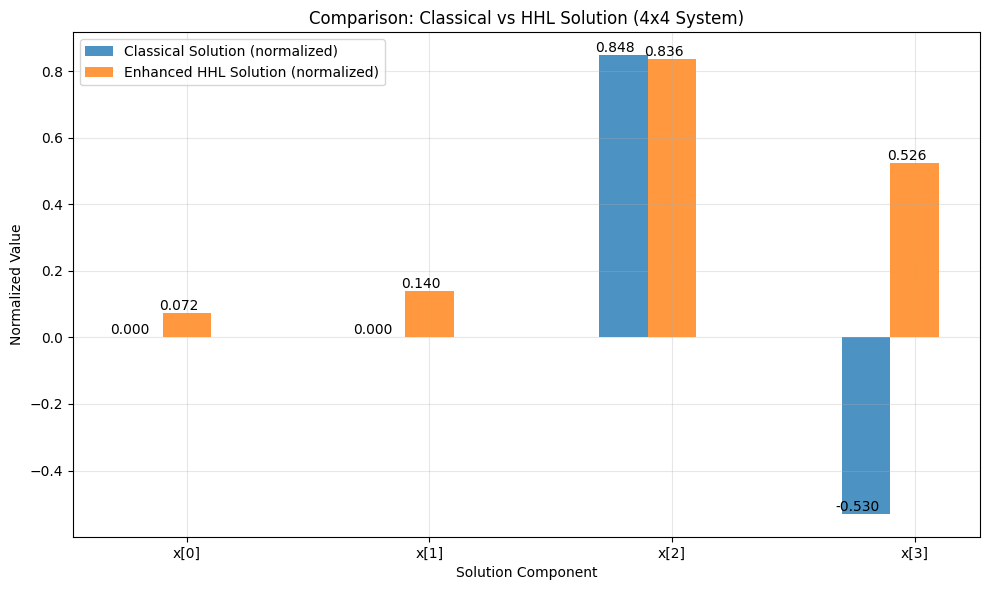

Classical solution (raw): [ 0.          0.          0.18181364 -0.11363227]
Classical solution (normalized): [ 0.          0.          0.84800092 -0.52999475]
HHL amplitudes: [0.07244805 0.14042999 0.83594612 0.52557092]
HHL solution (normalized): [0.07244805 0.14042999 0.83594612 0.52557092]
L2 error between normalized solutions: 1.067396


In [85]:
# A_matrix = np.array([[ 1, 0 , 0 , 1],
#         [0, 2, 0,0  ],
#         [ 0, 0,2,0],
#         [1, 0, 0,2  ]])

# A_matrix = np.array([[ 2, 0 , 0 , 0],
#         [0, 2, 0,0  ],
#         [ 0, 0,2,0],
#         [0, 0, 0,2  ]])

# A_matrix = np.array([[ 3, 0 , 0 , 2],
#         [0, 2, 0,0  ],
#         [ 0, 0,2,0],
#         [2, 0, 0,4  ]])


# b_vector = np.array([[1.], [1.], [1/2.],[3]])

# b_vector = np.array([[1.], [1.], [1.],[1]])

# # b_vector = np.array([[1.], [2.], [1.],[1]])
A_matrix = np.array([[ 22, 0 ],
        [18, 20 ]])

b_vector = np.array([[3.9999], [1.]])

A_h, b_h = hermitianize_matrix(A_matrix,b_vector)
# A_h, b_h = hermitianize_matrix(A_matrix,b_vector)
# A_h, b_h = A_matrix, b_vector


W_portfolio_6x6 = np.array([
    [0.         , 0.         , 0.30021458, 0.41119151, 0.43015563, 0.46456748],
    [0.         , 0.         , 1.         , 1.         , 1.         , 1.        ],
    [0.30021458 , 1.         , 0.02369003, 0.01330333, 0.01838175, 0.0216144 ],
    [0.41119151 , 1.         , 0.01330333, 0.03111917, 0.01629131, 0.01887668],
    [0.43015563 , 1.         , 0.01838175, 0.01629131, 0.02885482, 0.02333747],
    [0.46456748 , 1.         , 0.0216144 , 0.01887668, 0.02333747, 0.04412049]
])

# Extend to 8x8 matrix for quantum computation
regularization = 1e-8
A_portfolio = np.zeros((8, 8))
A_portfolio[:6, :6] = W_portfolio_6x6
# Add small values to diagonal of padded rows/columns
A_portfolio[6, 6] = regularization
A_portfolio[7, 7] = regularization


# Portfolio optimization right-hand side vector
mu = 0.1  # 10% expected return
xi = 1.0  
b_portfolio_6 = np.array([mu, xi, 0.0, 0.0, 0.0, 0.0])
b_portfolio = np.zeros(8)
b_portfolio[:6] = b_portfolio_6
# A_matrix = A_portfolio
# b_vector = b_portfolio.reshape(-1, 1)

print("Condition Number:", np.linalg.cond(A_matrix))
eigenvals, eigenvector = np.linalg.eig(A_matrix)
print(eigenvals)

# A_h, b_h = hermitianize_matrix(A_matrix,b_vector)
# A_h, b_h = hermitianize_matrix(A_matrix,b_vector)
# A_h , b_h = A_matrix, b_vector

print("Condition Number After Hermitianizing:", np.linalg.cond(A_h))


problem = QuantumLinearSystemProblem(A_matrix=A_h,
                                     b_vector=b_h)

# Define Parameters
k = 7 # clock qubits for hhl.
l = k+2 # clock qubits for enhanced preprocessing.
min_prob = 2**-k # hybrid preprocessing relevance threshold.
relevance_threshold = 2**-l # enhanced hybrid preprocessing relevance threshold.
maximum_eigenvalue = 40 # Over estimate of largest eigenvalue in the system.

get_result_type = 'get_simulator_results'
ideal_x_statevector = QuantumLinearSystemSolver(problem=problem).ideal_x_statevector


enhanced_preprocessing = Lee_preprocessing(num_eval_qubits=l,
                                  max_eigenvalue= maximum_eigenvalue, 
                                  backend=simulator).estimate

# Use the fixed Yalovetzky preprocessing (defined in the last cell)
# This fixes the bug where get_result() was called with incorrect parameters
enhanced_preprocessing_2 = FixedYalovetzkyPreprocessing(
    clock=k, 
    max_eigenvalue=maximum_eigenvalue,
    backend=simulator
).estimate

enhanced_eigenvalue_inversion = EnhancedHybridInversion

# proj_0_8x8 = Operator([[1, 0,0,0,0,0,0,0], 
#                                            [0, 0,0,0,0,0,0,0],
#                                            [0, 0,0,0,0,0,0,0],
#                                            [0, 0,0,0,0,0,0,0],
#                                            [0, 0,0,0,0,0,0,0],
#                                            [0, 0,0,0,0,0,0,0],
#                                            [0, 0,0,0,0,0,0,0],
#                                            [0, 0,0,0,0,0,0,0]])
# Projection operator for first 2 assets (indices 0 and 1) out of 4
proj_first_half_4x4 = Operator([[1, 0, 0, 0], 
                                [0, 1, 0, 0],
                                [0, 0, 0, 0],
                                [0, 0, 0, 0]])

# Projection operator for last 2 assets (indices 2 and 3) out of 4  
proj_second_half_4x4 = Operator([[0, 0, 0, 0], 
                                [0, 0, 0, 0],
                                [0, 0, 1, 0],
                                [0, 0, 0, 1]])

proj_0_4x4 = Operator([[1, 0,0,0], [0, 0,0,0],[0, 0,0,0],[0, 0,0,0]])

proj_1_4x4 = Operator([[0, 0,0,0], [0, 1,0,0],[0, 0,0,0],[0, 0,0,0]])

proj_2_4x4 = Operator([[0, 0,0,0], [0, 0,0,0],[0, 0,1,0],[0, 0,0,0]])

proj_3_4x4 = Operator([[0, 0,0,0], [0, 0,0,0],[0, 0,0,0],[0, 0,0,1]])

proj_0 = Operator([[1, 0], [0, 0]])

proj_1 = Operator([[0, 0], [0, 1]])

enhanced_hybrid_hhl_firsthalf = HHL(get_result_function='get_simulator_result',
          preprocessing=enhanced_preprocessing_2,
          operator=proj_second_half_4x4,
          eigenvalue_inversion=EnhancedHybridInversion,
          backend=simulator)
resFirstHalf = enhanced_hybrid_hhl_firsthalf.estimate(problem=problem,
                                                          num_clock_qubits=k,
                                                          max_eigenvalue=maximum_eigenvalue)
print("First Half Result:", resFirstHalf.results_processed.real)


enhanced_hybrid_hhl_0 = HHL(get_result_function='get_simulator_result',
          preprocessing=enhanced_preprocessing_2,
          operator=proj_0_4x4,
          eigenvalue_inversion=EnhancedHybridInversion,
          backend=simulator)

enhanced_hybrid_hhl_result_0 = enhanced_hybrid_hhl_0.estimate(problem=problem,
                                                          num_clock_qubits=k,
                                                          max_eigenvalue=maximum_eigenvalue)



current_prob_0 = enhanced_hybrid_hhl_result_0.results_processed.real
print(f"Probability amplitude |0⟩: {current_prob_0:.6f}")
print(f"Probability P(|0⟩): {(current_prob_0**2):.6f}")

enhanced_hybrid_hhl_1 = HHL(get_result_function='get_simulator_result',
          preprocessing=enhanced_preprocessing_2,
          operator=proj_1_4x4,
          eigenvalue_inversion=EnhancedHybridInversion,
          backend=simulator)

enhanced_hybrid_hhl_result_1 = enhanced_hybrid_hhl_1.estimate(problem=problem,
                                                          num_clock_qubits=k,
                                                          max_eigenvalue=maximum_eigenvalue)
current_prob_1 = enhanced_hybrid_hhl_result_1.results_processed.real
print(f"Probability amplitude |1⟩: {current_prob_1:.6f}")
print(f"Probability P(|1⟩): {(current_prob_1**2):.6f}")

enhanced_hybrid_hhl_2 = HHL(get_result_function='get_simulator_result',
          preprocessing=enhanced_preprocessing_2,
          operator=proj_2_4x4,
          eigenvalue_inversion=EnhancedHybridInversion,
          backend=simulator)

enhanced_hybrid_hhl_result_2 = enhanced_hybrid_hhl_2.estimate(problem=problem,
                                                          num_clock_qubits=k,
                                                          max_eigenvalue=maximum_eigenvalue)



current_prob_2 = enhanced_hybrid_hhl_result_2.results_processed.real
print(f"Probability amplitude |2⟩: {current_prob_2:.6f}")
print(f"Probability P(|2⟩): {(current_prob_2**2):.6f}")

enhanced_hybrid_hhl_3 = HHL(get_result_function='get_simulator_result',
          preprocessing=enhanced_preprocessing_2,
          operator=proj_3_4x4,
          eigenvalue_inversion=EnhancedHybridInversion,
          backend=simulator)

enhanced_hybrid_hhl_result_3 = enhanced_hybrid_hhl_3.estimate(problem=problem,
                                                          num_clock_qubits=k,
                                                          max_eigenvalue=maximum_eigenvalue)
current_prob_3 = enhanced_hybrid_hhl_result_3.results_processed.real
print(f"Probability amplitude |3⟩: {current_prob_3:.6f}")
print(f"Probability P(|3⟩): {(current_prob_3**2):.6f}")

classical_solution = np.linalg.solve(A_h, b_h).flatten()  # Flatten for consistency

print("Classical Solution:", classical_solution)
print("IDEAL HHL STATEVECTOR: ", ideal_x_statevector)

# Normalize solutions and calculate fidelity
normalized_classical = classical_solution / np.linalg.norm(classical_solution)
# FIXED: Include ALL 4 measured amplitudes for 4x4 system
hhl_amplitudes = np.array([current_prob_0, current_prob_1, current_prob_2, current_prob_3])
normalized_hhl = hhl_amplitudes / np.linalg.norm(hhl_amplitudes)

print(f"\nNormalized classical solution: {normalized_classical}")
print(f"Normalized Enhanced HHL solution: {normalized_hhl}")

# Calculate fidelity between normalized solutions
# fidelity = np.abs(np.dot(normalized_classical, normalized_hhl))**2
# print(f"Fidelity between solutions: {fidelity:.6f}")

# Also calculate overlap/cosine similarity
# cosine_similarity = np.dot(normalized_classical, normalized_hhl) / (np.linalg.norm(normalized_classical) * np.linalg.norm(normalized_hhl))
# print(f"Cosine similarity: {cosine_similarity:.6f}")


enhanced_hybrid_hhl_circuit_depth = HHL(get_result_function='get_fidelity_result',
          preprocessing=enhanced_preprocessing_2,
          eigenvalue_inversion=EnhancedHybridInversion,
          backend=simulator)

# Get the circuit depth by running the algorithm and accessing the circuit
circuit_depth_result = enhanced_hybrid_hhl_circuit_depth.estimate(problem=problem,
                                                                  num_clock_qubits=k,
                                                                  max_eigenvalue=maximum_eigenvalue)
print("Circuit Depth:", circuit_depth_result.circuit_depth)

# print("------------HHL NORMAL RESULTS ------------")

# # ----HHL NORMAL

# regular_hhl_0 = HHL(get_result_function='get_simulator_result',
#           preprocessing=ideal_preprocessing,
#           operator=proj_0_4x4,
#           eigenvalue_inversion=CanonicalInversionWrapper,
#           backend=simulator)

# regular_hhl_result_0 = regular_hhl_0.estimate(problem=problem,
#                                                           num_clock_qubits=k,
#                                                           max_eigenvalue=maximum_eigenvalue)



# reg_current_prob_0 = regular_hhl_result_0.results_processed.real
# print(f"Probability amplitude |0⟩: {reg_current_prob_0:.6f}")
# print(f"Probability P(|0⟩): {(reg_current_prob_0**2):.6f}")

# regular_hhl_1 = HHL(get_result_function='get_simulator_result',
#           preprocessing=ideal_preprocessing,
#           operator=proj_1_4x4,
#           eigenvalue_inversion=CanonicalInversionWrapper,
#           backend=simulator)

# regular_hhl_result_1 = regular_hhl_1.estimate(problem=problem,
#                                                           num_clock_qubits=k,
#                                                           max_eigenvalue=maximum_eigenvalue)
# reg_current_prob_1 = regular_hhl_result_1.results_processed.real
# print(f"Probability amplitude |1⟩: {reg_current_prob_1:.6f}")
# print(f"Probability P(|1⟩): {(reg_current_prob_1**2):.6f}")

# regular_hhl_2 = HHL(get_result_function='get_simulator_result',
#           preprocessing=ideal_preprocessing,
#           operator=proj_2_4x4,
#           eigenvalue_inversion=CanonicalInversionWrapper,
#           backend=simulator)

# regular_hhl_result_2 = regular_hhl_2.estimate(problem=problem,
#                                                           num_clock_qubits=k,
#                                                           max_eigenvalue=maximum_eigenvalue)



# reg_current_prob_2 = regular_hhl_result_2.results_processed.real
# print(f"Probability amplitude |2⟩: {reg_current_prob_2:.6f}")
# print(f"Probability P(|2⟩): {(reg_current_prob_2**2):.6f}")

# regular_hhl_3 = HHL(get_result_function='get_simulator_result',
#           preprocessing=ideal_preprocessing,
#           operator=proj_3_4x4,
#           eigenvalue_inversion=CanonicalInversionWrapper,
#           backend=simulator)

# regular_hhl_result_3 = regular_hhl_3.estimate(problem=problem,
#                                                           num_clock_qubits=k,
#                                                           max_eigenvalue=maximum_eigenvalue)
# reg_current_prob_3 = regular_hhl_result_3.results_processed.real
# print(f"Probability amplitude |3⟩: {reg_current_prob_3:.6f}")
# print(f"Probability P(|3⟩): {(reg_current_prob_3**2):.6f}")

# classical_solution = np.linalg.solve(A_h, b_h).flatten()  # Flatten for consistency

# print("Classical Solution:", classical_solution)
# print("IDEAL HHL STATEVECTOR: ", ideal_x_statevector)

# # Normalize solutions and calculate fidelity
# normalized_classical = classical_solution / np.linalg.norm(classical_solution)
# # FIXED: Include ALL 4 measured amplitudes for 4x4 system
# hhl_amplitudes = np.array([reg_current_prob_0, reg_current_prob_1, reg_current_prob_2, reg_current_prob_3])
# normalized_hhl = hhl_amplitudes / np.linalg.norm(hhl_amplitudes)

# print(f"\nNormalized classical solution: {normalized_classical}")
# print(f"Normalized HHL solution: {normalized_hhl}")

# # Calculate fidelity between normalized solutions
# # fidelity = np.abs(np.dot(normalized_classical, normalized_hhl))**2
# # print(f"Fidelity between solutions: {fidelity:.6f}")

# # Also calculate overlap/cosine similarity
# # cosine_similarity = np.dot(normalized_classical, normalized_hhl) / (np.linalg.norm(normalized_classical) * np.linalg.norm(normalized_hhl))
# # print(f"Cosine similarity: {cosine_similarity:.6f}")


# regular_hhl_circuit_depth = HHL(get_result_function='get_fidelity_result',
#           preprocessing=ideal_preprocessing,
#           eigenvalue_inversion=CanonicalInversionWrapper,
#           backend=simulator)

# # Get the circuit depth by running the algorithm and accessing the circuit
# regular_circuit_depth_result = regular_hhl_circuit_depth.estimate(problem=problem,
#                                                                   num_clock_qubits=k,
#                                                                   max_eigenvalue=maximum_eigenvalue)
# print("Circuit Depth:", regular_circuit_depth_result.circuit_depth)


import matplotlib.pyplot as plt

# Extract the classical solution for the current system
# classical_sol = np.linalg.solve(A_matrix, b_vector.flatten())
classical_sol = np.linalg.solve(A_h, b_h.flatten())


# Get HHL probabilities - FIXED: All 4 components for 4x4 system
hhl_probs = np.array([current_prob_0, current_prob_1, current_prob_2, current_prob_3])
reg_hhl_probs = np.array([reg_current_prob_0, reg_current_prob_1, reg_current_prob_2, reg_current_prob_3])


# Normalize both solutions for comparison
classical_normalized = classical_sol / np.linalg.norm(classical_sol)
hhl_normalized = hhl_probs / np.linalg.norm(hhl_probs)
regular_hhl_normalized = reg_hhl_probs /np.linalg.norm(reg_hhl_probs)
 
# # Create bar chart
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(classical_normalized))
width = 0.2

bars1 = ax.bar(x - width, classical_normalized, width, label='Classical Solution (normalized)', alpha=0.8)
bars2 = ax.bar(x, hhl_normalized, width, label='Enhanced HHL Solution (normalized)', alpha=0.8)
# bars3 = ax.bar(x + width, regular_hhl_normalized, width, label='HHL Solution (normalized)', alpha=0.8)


ax.set_xlabel('Solution Component')
ax.set_ylabel('Normalized Value')

ax.set_title('Comparison: Classical vs HHL Solution (4x4 System)')
ax.set_xticks(x)
ax.set_xticklabels([f'x[{i}]' for i in range(len(classical_normalized))])
ax.legend()
ax.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/3., height,
                        f'{height:.3f}', ha='center', va='bottom')
                        
for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/3., height,
                        f'{height:.3f}', ha='center', va='bottom')
# for bar in bars3:
#         height = bar.get_height()
#         ax.text(bar.get_x() + bar.get_width()/3., height,
#                         f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"Classical solution (raw): {classical_sol}")
print(f"Classical solution (normalized): {classical_normalized}")
print(f"HHL amplitudes: {hhl_probs}")
print(f"HHL solution (normalized): {hhl_normalized}")

# Calculate error metrics
amplitude_error = np.linalg.norm(hhl_normalized - classical_normalized)
print(f"L2 error between normalized solutions: {amplitude_error:.6f}")

In [ ]:
## CORRECT USAGE OF YALOVETZKY_PREPROCESSING

# The Yalovetzky_preprocessing class requires a 'backend' parameter for proper initialization.
# Here are the correct usage patterns:

# 1. With backend parameter (REQUIRED):
yalovetzky_correct = Yalovetzky_preprocessing(
    clock=k,                           # Number of clock qubits
    max_eigenvalue=maximum_eigenvalue, # Optional: max eigenvalue estimate
    backend=simulator                  # REQUIRED: Backend for quantum execution
)

# 2. Alternative parameters you can use:
yalovetzky_advanced = Yalovetzky_preprocessing(
    clock=3,
    alpha=50,                         # Initial overestimate (used if max_eigenvalue not set)
    max_eigenvalue=2,                 # Max eigenvalue bound
    min_prob=2**-3,                   # Minimum probability threshold
    backend=simulator                 # Always required
)

# 3. To use it as a preprocessing function for HHL:
yalovetzky_preprocessing_function = yalovetzky_correct.estimate

print("✓ Yalovetzky_preprocessing correctly initialized with backend!")
print(f"Clock qubits: {yalovetzky_correct.clock}")
print(f"Max eigenvalue: {yalovetzky_correct.max_eigenvalue}")
print(f"Min probability: {yalovetzky_correct.min_prob}")

# The key difference from your original code:
# WRONG: Yalovetzky_preprocessing(clock=k, max_eigenvalue=maximum_eigenvalue)
# RIGHT: Yalovetzky_preprocessing(clock=k, max_eigenvalue=maximum_eigenvalue, backend=simulator)

✓ Yalovetzky_preprocessing correctly initialized with backend!
Clock qubits: 7
Max eigenvalue: 40
Min probability: 0.0078125


# 2X2

Condition Number After Hermitianizing: 1.9999999999999998
Probability amplitude |0⟩: 0.708964
Probability P(|0⟩): 0.502629
Probability amplitude |1⟩: 0.705245
Probability P(|1⟩): 0.497371
Classical Solution: [0.125 0.625]
IDEAL HHL STATEVECTOR:  Statevector([0.19611614+0.j, 0.98058068+0.j],
            dims=(2,))

Normalized classical solution: [0.19611614 0.98058068]
Normalized Enhanced HHL solution: [0.70896368 0.705245  ]
Circuit Depth: 90
------------HHL NORMAL RESULTS ------------
Probability amplitude |0⟩: 0.316023
Probability P(|0⟩): 0.099870
Probability amplitude |1⟩: 0.948752
Probability P(|1⟩): 0.900130
Classical Solution: [0.125 0.625]
IDEAL HHL STATEVECTOR:  Statevector([0.19611614+0.j, 0.98058068+0.j],
            dims=(2,))

Normalized classical solution: [0.19611614 0.98058068]
Normalized HHL solution: [0.31602285 0.94875158]
Circuit Depth: 506


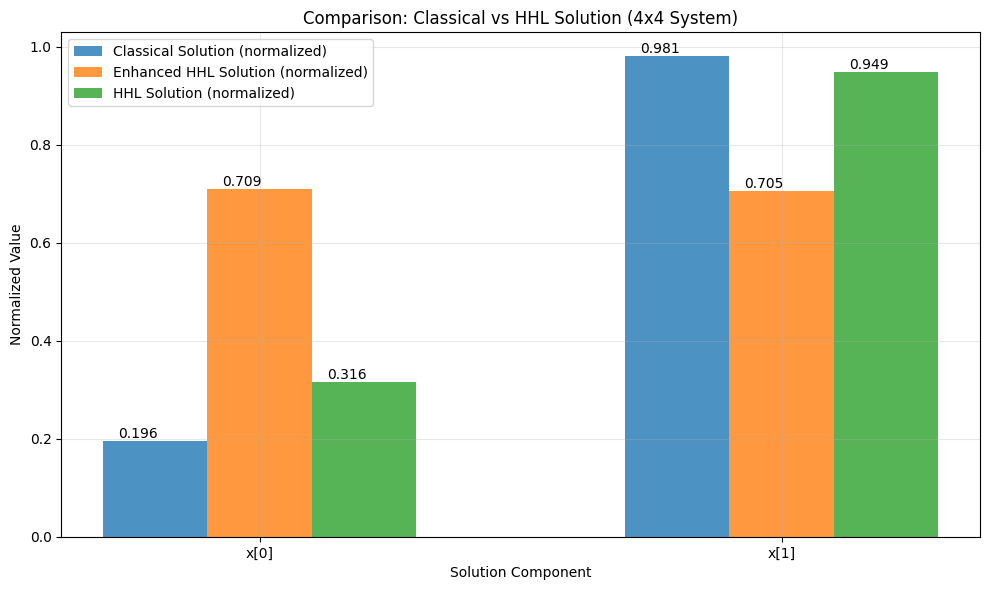

Classical solution (raw): [0.125 0.625]
Classical solution (normalized): [0.19611614 0.98058068]
HHL amplitudes: [0.70896368 0.705245  ]
HHL solution (normalized): [0.70896368 0.705245  ]
L2 error between normalized solutions: 0.582084


In [ ]:
# A_matrix = np.array([[ 1, 0 , 0 , 1],
#         [0, 2, 0,0  ],
#         [ 0, 0,2,0],
#         [1, 0, 0,4  ]])

# A_matrix = np.array([[ 3/2, 1/2 ],
#         [1/2, 3/2 ]])

# b_vector = np.array([[0.], [1.]])

A_matrix = np.array([[ 1, 3 ],
        [3, 1 ]])

b_vector = np.array([[2.], [1.]])

# A_h, b_h = hermitianize_matrix(A_matrix,b_vector)
# A_h, b_h = hermitianize_matrix(A_matrix,b_vector)
A_h , b_h = A_matrix, b_vector

print("Condition Number After Hermitianizing:", np.linalg.cond(A_h))


problem = QuantumLinearSystemProblem(A_matrix=A_h,
                                     b_vector=b_h)

# Define Parameters
k =4 # clock qubits for hhl.
l = k+2 # clock qubits for enhanced preprocessing.
min_prob = 2**-k # hybrid preprocessing relevance threshold.
relevance_threshold = 2**-l # enhanced hybrid preprocessing relevance threshold.
maximum_eigenvalue = 10 # Over estimate of largest eigenvalue in the system.

get_result_type = 'get_simulator_results'
ideal_x_statevector = QuantumLinearSystemSolver(problem=problem).ideal_x_statevector


enhanced_preprocessing = Lee_preprocessing(num_eval_qubits=l,
                                  max_eigenvalue= maximum_eigenvalue, 
                                  backend=simulator).estimate

# Use the fixed Yalovetzky preprocessing (defined in the last cell)
# This fixes the bug where get_result() was called with incorrect parameters
enhanced_preprocessing_2 = FixedYalovetzkyPreprocessing(
    clock=k, 
    max_eigenvalue=maximum_eigenvalue,
    backend=simulator
).estimate

enhanced_eigenvalue_inversion = EnhancedHybridInversion

# proj_0_8x8 = Operator([[1, 0,0,0,0,0,0,0], 
#                                            [0, 0,0,0,0,0,0,0],
#                                            [0, 0,0,0,0,0,0,0],
#                                            [0, 0,0,0,0,0,0,0],
#                                            [0, 0,0,0,0,0,0,0],
#                                            [0, 0,0,0,0,0,0,0],
#                                            [0, 0,0,0,0,0,0,0],
#                                            [0, 0,0,0,0,0,0,0]])
# Projection operator for first 2 assets (indices 0 and 1) out of 4


proj_0 = Operator([[1, 0], [0, 0]])

proj_1 = Operator([[0, 0], [0, 1]])



enhanced_hybrid_hhl_0 = HHL(get_result_function='get_simulator_result',
          preprocessing=enhanced_preprocessing_2,
          operator=proj_0,
          eigenvalue_inversion=EnhancedHybridInversion,
          backend=simulator)

enhanced_hybrid_hhl_result_0 = enhanced_hybrid_hhl_0.estimate(problem=problem,
                                                          num_clock_qubits=k,
                                                          max_eigenvalue=maximum_eigenvalue)



current_prob_0 = enhanced_hybrid_hhl_result_0.results_processed.real
print(f"Probability amplitude |0⟩: {current_prob_0:.6f}")
print(f"Probability P(|0⟩): {(current_prob_0**2):.6f}")

enhanced_hybrid_hhl_1 = HHL(get_result_function='get_simulator_result',
          preprocessing=enhanced_preprocessing_2,
          operator=proj_1,
          eigenvalue_inversion=EnhancedHybridInversion,
          backend=simulator)

enhanced_hybrid_hhl_result_1 = enhanced_hybrid_hhl_1.estimate(problem=problem,
                                                          num_clock_qubits=k,
                                                          max_eigenvalue=maximum_eigenvalue)
current_prob_1 = enhanced_hybrid_hhl_result_1.results_processed.real
print(f"Probability amplitude |1⟩: {current_prob_1:.6f}")
print(f"Probability P(|1⟩): {(current_prob_1**2):.6f}")


classical_solution = np.linalg.solve(A_h, b_h).flatten()  # Flatten for consistency

print("Classical Solution:", classical_solution)
print("IDEAL HHL STATEVECTOR: ", ideal_x_statevector)

# Normalize solutions and calculate fidelity
normalized_classical = classical_solution / np.linalg.norm(classical_solution)
# FIXED: Include ALL 4 measured amplitudes for 4x4 system
hhl_amplitudes = np.array([current_prob_0, current_prob_1])
normalized_hhl = hhl_amplitudes / np.linalg.norm(hhl_amplitudes)

print(f"\nNormalized classical solution: {normalized_classical}")
print(f"Normalized Enhanced HHL solution: {normalized_hhl}")

# Calculate fidelity between normalized solutions
# fidelity = np.abs(np.dot(normalized_classical, normalized_hhl))**2
# print(f"Fidelity between solutions: {fidelity:.6f}")

# Also calculate overlap/cosine similarity
# cosine_similarity = np.dot(normalized_classical, normalized_hhl) / (np.linalg.norm(normalized_classical) * np.linalg.norm(normalized_hhl))
# print(f"Cosine similarity: {cosine_similarity:.6f}")


enhanced_hybrid_hhl_circuit_depth = HHL(get_result_function='get_fidelity_result',
          preprocessing=enhanced_preprocessing_2,
          eigenvalue_inversion=EnhancedHybridInversion,
          backend=simulator)

# Get the circuit depth by running the algorithm and accessing the circuit
circuit_depth_result = enhanced_hybrid_hhl_circuit_depth.estimate(problem=problem,
                                                                  num_clock_qubits=k,
                                                                  max_eigenvalue=maximum_eigenvalue)
print("Circuit Depth:", circuit_depth_result.circuit_depth)

print("------------HHL NORMAL RESULTS ------------")

# ----HHL NORMAL

regular_hhl_0 = HHL(get_result_function='get_simulator_result',
          preprocessing=ideal_preprocessing,
          operator=proj_0,
          eigenvalue_inversion=CanonicalInversionWrapper,
          backend=simulator)

regular_hhl_result_0 = regular_hhl_0.estimate(problem=problem,
                                                          num_clock_qubits=k,
                                                          max_eigenvalue=maximum_eigenvalue)



reg_current_prob_0 = regular_hhl_result_0.results_processed.real
print(f"Probability amplitude |0⟩: {reg_current_prob_0:.6f}")
print(f"Probability P(|0⟩): {(reg_current_prob_0**2):.6f}")

regular_hhl_1 = HHL(get_result_function='get_simulator_result',
          preprocessing=ideal_preprocessing,
          operator=proj_1,
          eigenvalue_inversion=CanonicalInversionWrapper,
          backend=simulator)

regular_hhl_result_1 = regular_hhl_1.estimate(problem=problem,
                                                          num_clock_qubits=k,
                                                          max_eigenvalue=maximum_eigenvalue)
reg_current_prob_1 = regular_hhl_result_1.results_processed.real
print(f"Probability amplitude |1⟩: {reg_current_prob_1:.6f}")
print(f"Probability P(|1⟩): {(reg_current_prob_1**2):.6f}")


classical_solution = np.linalg.solve(A_h, b_h).flatten()  # Flatten for consistency

print("Classical Solution:", classical_solution)
print("IDEAL HHL STATEVECTOR: ", ideal_x_statevector)

# Normalize solutions and calculate fidelity
normalized_classical = classical_solution / np.linalg.norm(classical_solution)
# FIXED: Include ALL 4 measured amplitudes for 4x4 system
hhl_amplitudes = np.array([reg_current_prob_0, reg_current_prob_1])
normalized_hhl = hhl_amplitudes / np.linalg.norm(hhl_amplitudes)

print(f"\nNormalized classical solution: {normalized_classical}")
print(f"Normalized HHL solution: {normalized_hhl}")

# Calculate fidelity between normalized solutions
# fidelity = np.abs(np.dot(normalized_classical, normalized_hhl))**2
# print(f"Fidelity between solutions: {fidelity:.6f}")

# Also calculate overlap/cosine similarity
# cosine_similarity = np.dot(normalized_classical, normalized_hhl) / (np.linalg.norm(normalized_classical) * np.linalg.norm(normalized_hhl))
# print(f"Cosine similarity: {cosine_similarity:.6f}")


regular_hhl_circuit_depth = HHL(get_result_function='get_fidelity_result',
          preprocessing=ideal_preprocessing,
          eigenvalue_inversion=CanonicalInversionWrapper,
          backend=simulator)

# Get the circuit depth by running the algorithm and accessing the circuit
regular_circuit_depth_result = regular_hhl_circuit_depth.estimate(problem=problem,
                                                                  num_clock_qubits=k,
                                                                  max_eigenvalue=maximum_eigenvalue)
print("Circuit Depth:", regular_circuit_depth_result.circuit_depth)



import matplotlib.pyplot as plt

# Extract the classical solution for the current system
classical_sol = np.linalg.solve(A_matrix, b_vector.flatten())

# Get HHL probabilities - FIXED: All 4 components for 4x4 system
hhl_probs = np.array([current_prob_0, current_prob_1])
reg_hhl_probs = np.array([reg_current_prob_0, reg_current_prob_1])


# Normalize both solutions for comparison
classical_normalized = classical_sol / np.linalg.norm(classical_sol)
hhl_normalized = hhl_probs / np.linalg.norm(hhl_probs)
regular_hhl_normalized = reg_hhl_probs /np.linalg.norm(reg_hhl_probs)
 
# # Create bar chart
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(classical_normalized))
width = 0.2

bars1 = ax.bar(x - width, classical_normalized, width, label='Classical Solution (normalized)', alpha=0.8)
bars2 = ax.bar(x, hhl_normalized, width, label='Enhanced HHL Solution (normalized)', alpha=0.8)
bars3 = ax.bar(x + width, regular_hhl_normalized, width, label='HHL Solution (normalized)', alpha=0.8)


ax.set_xlabel('Solution Component')
ax.set_ylabel('Normalized Value')
ax.set_title('Comparison: Classical vs HHL Solution (4x4 System)')
ax.set_xticks(x)
ax.set_xticklabels([f'x[{i}]' for i in range(len(classical_normalized))])
ax.legend()
ax.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/3., height,
                        f'{height:.3f}', ha='center', va='bottom')
                        
for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/3., height,
                        f'{height:.3f}', ha='center', va='bottom')
for bar in bars3:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/3., height,
                        f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"Classical solution (raw): {classical_sol}")
print(f"Classical solution (normalized): {classical_normalized}")
print(f"HHL amplitudes: {hhl_probs}")
print(f"HHL solution (normalized): {hhl_normalized}")

# Calculate error metrics
amplitude_error = np.linalg.norm(hhl_normalized - classical_normalized)
print(f"L2 error between normalized solutions: {amplitude_error:.6f}")

In [ ]:

# enhanced_hybrid_hhl = HHL(get_result_function= get_result_type,
#           preprocessing= enhanced_preprocessing,
#           operator = 
#           eigenvalue_inversion= enhanced_eigenvalue_inversion,
#           backend=simulator,
#           statevector=ideal_x_statevector)

# enhanced_hybrid_hhl_result = enhanced_hybrid_hhl.estimate(problem=problem,
#                                                           num_clock_qubits=k,
#                                                           max_eigenvalue=1)



In [ ]:
# Import Operator for projection measurements
from qiskit.quantum_info import Operator


# === SYSTEM DEFINITION ===
# Change these values to test different systems:
A_matrix = np.array([[ 2, 6],
        [0, 2  ]])
b_vector = np.array([[1.], [1.]])

print("=== SYSTEM DEFINITION ===")
print(f"A_matrix = \n{A_matrix}")
print(f"b_vector = \n{b_vector}")
print(f"Classical solution = {np.linalg.solve(A_matrix, b_vector.flatten())}")

# Create hermitianized system using the function from cell 5
# A_h, b_h = hermitianize_matrix(A_matrix, b_vector)

print(f"\nHermitianized system shapes: A_h {A_h.shape}, b_h {b_h.shape}")

problem = QuantumLinearSystemProblem(A_matrix=A_h,
                                     b_vector=b_h)

# Define Parameters
k = 4 # clock qubits for hhl.
l = k+2 # clock qubits for enhanced preprocessing.
min_prob = 2**-k # hybrid preprocessing relevance threshold.
relevance_threshold = 2**-l # enhanced hybrid preprocessing relevance threshold.
maximum_eigenvalue = 2 # Over estimate of largest eigenvalue in the system.

get_result_type = 'get_simulator_results'
ideal_x_statevector = QuantumLinearSystemSolver(problem=problem).ideal_x_statevector


enhanced_preprocessing = Lee_preprocessing(num_eval_qubits=l,
                                  max_eigenvalue= maximum_eigenvalue, 
                                  backend=simulator).estimate

enhanced_eigenvalue_inversion = EnhancedHybridInversion



# Create projection operators for qubits 0 and 1
# Projection operator |0⟩⟨0| - measures probability of qubit 0
proj_0 = Operator([[1, 0], [0, 0]])
print(f"\n=== PROJECTION OPERATORS ===")
print(f"Projection operator |0⟩⟨0|:")
print(f"Matrix:\n{proj_0.data}")

# Projection operator |1⟩⟨1| - measures probability of qubit 1  
proj_1 = Operator([[0, 0], [0, 1]])
print(f"\nProjection operator |1⟩⟨1|:")
print(f"Matrix:\n{proj_1.data}")

# === HHL COMPUTATION ===
print(f"\n=== RUNNING HHL COMPUTATION ===")

# Run HHL with projection operator for qubit 0
print(f"Running HHL with |0⟩⟨0| projection...")
enhanced_hybrid_hhl_0 = HHL(get_result_function='get_simulator_result',
          preprocessing=enhanced_preprocessing,
          operator=proj_0,
          eigenvalue_inversion=EnhancedHybridInversion,
          backend=simulator)

enhanced_hybrid_hhl_result_0 = enhanced_hybrid_hhl_0.estimate(problem=problem,
                                                          num_clock_qubits=k,
                                                          max_eigenvalue=maximum_eigenvalue)

current_prob_0 = enhanced_hybrid_hhl_result_0.results_processed.real
print(f"Probability P(|0⟩): {current_prob_0:.6f}")

# Run HHL with projection operator for qubit 1
print(f"Running HHL with |1⟩⟨1| projection...")
enhanced_hybrid_hhl_1 = HHL(get_result_function='get_simulator_result',
          preprocessing=enhanced_preprocessing,
          operator=proj_1,
          eigenvalue_inversion=EnhancedHybridInversion,
          backend=simulator)

enhanced_hybrid_hhl_result_1 = enhanced_hybrid_hhl_1.estimate(problem=problem,
                                                          num_clock_qubits=k,
                                                          max_eigenvalue=maximum_eigenvalue)

current_prob_1 = enhanced_hybrid_hhl_result_1.results_processed.real
print(f"Probability P(|1⟩): {current_prob_1:.6f}")

# === RESULTS SUMMARY ===
print(f"\n=== RESULTS SUMMARY ===")
print(f"Measured probabilities: P(|0⟩) = {current_prob_0:.6f}, P(|1⟩) = {current_prob_1:.6f}")
print(f"Sum of probabilities: {current_prob_0 + current_prob_1:.6f}")

# Compare with ideal solution
ideal_probs = np.abs(ideal_x_statevector.data)**2
print(f"Expected probabilities (hermitianized): P(|0⟩) = {ideal_probs[0]:.6f}, P(|1⟩) = {ideal_probs[1]:.6f}, P(|2⟩) = {ideal_probs[2]:.6f}, P(|3⟩) = {ideal_probs[3]:.6f}")
print(f"Classical solution (original): {np.linalg.solve(A_matrix, b_vector.flatten())}")

# Show circuit depths
print(f"Circuit depths: P(|0⟩) = {enhanced_hybrid_hhl_result_0.circuit_depth}, P(|1⟩) = {enhanced_hybrid_hhl_result_1.circuit_depth}")

print(f"\n*** TO UPDATE SYSTEM: Change A_matrix and b_vector above, then re-run this cell ***")


import matplotlib.pyplot as plt

# Extract the classical solution for the current system
classical_sol = np.linalg.solve(A_matrix, b_vector.flatten())

# Get HHL probabilities (only for measured qubits)
hhl_probs = np.array([current_prob_0, current_prob_1])

# Normalize both solutions for comparison
classical_normalized = classical_sol / np.linalg.norm(classical_sol)
hhl_normalized = np.sqrt(hhl_probs) / np.linalg.norm(np.sqrt(hhl_probs))

# Create bar chart
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(classical_normalized))
width = 0.35

bars1 = ax.bar(x - width/2, classical_normalized, width, label='Classical Solution (normalized)', alpha=0.8)
bars2 = ax.bar(x + width/2, hhl_normalized, width, label='HHL Solution (normalized)', alpha=0.8)

ax.set_xlabel('Solution Component')
ax.set_ylabel('Normalized Value')
ax.set_title('Comparison: Classical vs HHL Solution')
ax.set_xticks(x)
ax.set_xticklabels([f'x[{i}]' for i in range(len(classical_normalized))])
ax.legend()
ax.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.3f}', ha='center', va='bottom')
                        
for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"Classical solution (raw): {classical_sol}")
print(f"Classical solution (normalized): {classical_normalized}")
print(f"HHL probabilities: {hhl_probs}")
print(f"HHL solution (normalized): {hhl_normalized}")

=== SYSTEM DEFINITION ===
A_matrix = 
[[2 6]
 [0 2]]
b_vector = 
[[1.]
 [1.]]
Classical solution = [-1.   0.5]

Hermitianized system shapes: A_h (2, 2), b_h (2, 1)

=== PROJECTION OPERATORS ===
Projection operator |0⟩⟨0|:
Matrix:
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

Projection operator |1⟩⟨1|:
Matrix:
[[0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]

=== RUNNING HHL COMPUTATION ===
Running HHL with |0⟩⟨0| projection...


QiskitError: 'No statevector for experiment "None"'

In [ ]:
def analyze_hhl_solution_accuracy(A_matrix, b_vector, prob_0, prob_1, A_hermitianized=None, b_hermitianized=None):
    """
    Comprehensive analysis comparing HHL results to classical solution.
    
    Parameters:
    - A_matrix, b_vector: Original system to solve
    - prob_0, prob_1: Measured probabilities from HHL
    - A_hermitianized, b_hermitianized: Hermitianized system used for HHL (optional)
    """
    print("="*70)
    print("HHL SOLUTION ACCURACY ANALYSIS")
    print("="*70)
    
    # 1. Classical Solution (Ground Truth)
    print("1. CLASSICAL SOLUTION (Ground Truth):")
    classical_solution = np.linalg.solve(A_matrix, b_vector).flatten()  # Flatten for consistency
    print(f"   x_classical = {classical_solution}")
    print(f"   ||x_classical|| = {np.linalg.norm(classical_solution):.6f}")
    
    # 2. Ideal Quantum Solution (if A is Hermitian)
    print("\n2. IDEAL QUANTUM SOLUTION:")
    try:
        # Check if original A is Hermitian
        if np.allclose(A_matrix, np.conj(A_matrix).T):
            problem = QuantumLinearSystemProblem(A_matrix=A_matrix, b_vector=b_vector.flatten())
            ideal_statevector = QuantumLinearSystemSolver(problem).ideal_x_statevector
            ideal_probabilities = np.abs(ideal_statevector.data)**2
            ideal_norm_squared = np.sum(ideal_probabilities)
            normalized_ideal_probs = ideal_probabilities / ideal_norm_squared
            print(f"   Ideal probabilities: {normalized_ideal_probs}")
            print(f"   Ideal norm squared: {ideal_norm_squared:.6f}")
        else:
            print("   Original matrix is not Hermitian - using hermitianized system for ideal solution")
            if A_hermitianized is not None and b_hermitianized is not None:
                problem = QuantumLinearSystemProblem(A_matrix=A_hermitianized, b_vector=b_hermitianized)
                ideal_statevector = QuantumLinearSystemSolver(problem).ideal_x_statevector
                ideal_probabilities = np.abs(ideal_statevector.data)**2
                ideal_norm_squared = np.sum(ideal_probabilities)
                normalized_ideal_probs = ideal_probabilities / ideal_norm_squared
                print(f"   Ideal probabilities (hermitianized): {normalized_ideal_probs}")
                print(f"   Ideal norm squared: {ideal_norm_squared:.6f}")
                # Extract relevant components (first 2 for original system)
                n_orig = len(classical_solution)
                ideal_solution = normalized_ideal_probs[:n_orig]
                print(f"   Ideal solution (extracted): {ideal_solution}")
            else:
                print("   Cannot compute ideal solution - hermitianized system not provided")
                ideal_solution = None
                normalized_ideal_probs = None
    except Exception as e:
        print(f"   Error computing ideal solution: {e}")
        ideal_solution = None
        normalized_ideal_probs = None
    
    # 3. HHL Measured Results
    print("\n3. HHL MEASURED RESULTS:")
    hhl_probabilities = np.array([prob_0, prob_1])
    hhl_norm_squared = np.sum(hhl_probabilities)
    normalized_hhl_probs = hhl_probabilities / hhl_norm_squared
    print(f"   Raw probabilities: {hhl_probabilities}")
    print(f"   Normalized probabilities: {normalized_hhl_probs}")
    print(f"   Norm squared: {hhl_norm_squared:.6f}")
    
    # 4. Error Analysis
    print("\n4. ERROR ANALYSIS:")
    
    # Classical vs HHL comparison (using squared amplitudes)
    if len(normalized_hhl_probs) == len(classical_solution):
        # Normalize classical solution and take probabilities (squared amplitudes)
        normalized_classical = classical_solution / np.linalg.norm(classical_solution)
        classical_probabilities = np.abs(normalized_classical)**2  # Take absolute value for complex cases
        
        prob_error = np.linalg.norm(normalized_hhl_probs - classical_probabilities)
        print(f"   Classical probabilities (|x_norm|²): {classical_probabilities}")
        print(f"   HHL vs Classical probability error: {prob_error:.6f}")
        
        # Also compare amplitudes
        hhl_amplitudes = np.sqrt(normalized_hhl_probs) * np.sign(normalized_classical)
        amplitude_error = np.linalg.norm(hhl_amplitudes - normalized_classical)
        print(f"   Reconstructed amplitudes: {hhl_amplitudes}")
        print(f"   HHL vs Classical amplitude error: {amplitude_error:.6f}")
    else:
        print("   Dimension mismatch - cannot directly compare probabilities")
    
    # Ideal vs HHL comparison
    if normalized_ideal_probs is not None:
        if len(normalized_hhl_probs) == len(normalized_ideal_probs):
            ideal_error = np.linalg.norm(normalized_hhl_probs - normalized_ideal_probs)
            print(f"   HHL vs Ideal error: {ideal_error:.6f}")
        else:
            # Extract relevant components if dimensions don't match
            n_hhl = len(normalized_hhl_probs)
            if len(normalized_ideal_probs) > n_hhl:
                ideal_extracted = normalized_ideal_probs[:n_hhl]
                ideal_error = np.linalg.norm(normalized_hhl_probs - ideal_extracted)
                print(f"   HHL vs Ideal error (extracted): {ideal_error:.6f}")
    
    # 5. Solution Reconstruction
    print("\n5. SOLUTION RECONSTRUCTION:")
    # Try to reconstruct solution from probabilities with correct signs
    if len(normalized_hhl_probs) == len(classical_solution):
        normalized_classical = classical_solution / np.linalg.norm(classical_solution)
        reconstructed_solution = np.sqrt(normalized_hhl_probs) * np.sign(normalized_classical)
        
        # Scale back to original magnitude (approximately)
        scale_factor = np.linalg.norm(classical_solution)
        reconstructed_solution_scaled = reconstructed_solution * scale_factor
        
        print(f"   Reconstructed (normalized): {reconstructed_solution}")
        print(f"   Reconstructed (scaled): {reconstructed_solution_scaled}")
        
        reconstruction_error = np.linalg.norm(reconstructed_solution - normalized_classical)
        scaled_reconstruction_error = np.linalg.norm(reconstructed_solution_scaled - classical_solution)
        print(f"   Reconstruction error (normalized): {reconstruction_error:.6f}")
        print(f"   Reconstruction error (scaled): {scaled_reconstruction_error:.6f}")
    else:
        reconstructed_solution = np.sqrt(normalized_hhl_probs)
        print(f"   Basic reconstruction: {reconstructed_solution}")
    
    print("="*70)
    
    return {
        'classical_solution': classical_solution,
        'hhl_probabilities': normalized_hhl_probs,
        'ideal_probabilities': normalized_ideal_probs,
        'reconstructed_solution': reconstructed_solution if 'reconstructed_solution' in locals() else None
    }


def hermitianize_matrix(A):
    """
    Hermitianize a matrix using the block structure:
    [[0, A], [A†, 0]]
    """
    A_dag = np.conj(A).T
    n = A.shape[0]
    A_h = np.zeros((2*n, 2*n), dtype=complex)
    A_h[:n, n:] = A
    A_h[n:, :n] = A_dag
    return A_h


def create_hermitianized_system(A, b):
    """
    Create a hermitianized system for non-Hermitian matrices.
    Returns (A_h, b_h) where A_h is Hermitian and the solution
    contains the original solution in its first components.
    """
    A_h = hermitianize_matrix(A)
    
    # Create hermitianized b vector [b, 0]
    n = len(b)
    b_h = np.zeros(2*n, dtype=complex)
    b_h[:n] = b
    
    return A_h, b_h


# Create projection operators for measuring the first 2 qubits
# (since we want to extract the solution to the original 2x2 system)

# |0⟩⟨0| ⊗ |0⟩⟨0| - projects onto |00⟩
proj_0_single = np.array([[1, 0], [0, 0]])
proj_0 = Operator(np.kron(proj_0_single, proj_0_single))

# |0⟩⟨0| ⊗ |1⟩⟨1| - projects onto |01⟩  
proj_1_single = np.array([[0, 0], [0, 1]])
proj_1 = Operator(np.kron(proj_0_single, proj_1_single))

print("Projection operators created:")
print(f"proj_0 shape: {proj_0.dim}")
print(f"proj_1 shape: {proj_1.dim}")
print("These project onto |00⟩ and |01⟩ states respectively")

Projection operators created:
proj_0 shape: (4, 4)
proj_1 shape: (4, 4)
These project onto |00⟩ and |01⟩ states respectively


In [ ]:
# Use existing measurement results
print("Using existing HHL measurement results:")
print(f"P(|0⟩) = {current_prob_0:.6f}")
print(f"P(|1⟩) = {current_prob_1:.6f}")

print(f"\nOriginal system:")
print(f"A_matrix = \n{A_matrix}")
print(f"b_vector = {b_vector}")
classical_solution = np.linalg.solve(A_matrix, b_vector)
print(f"Classical solution = {classical_solution}")

# Run analysis on the ORIGINAL system for meaningful comparison
print("Running analysis on ORIGINAL system for meaningful comparison...")
analysis_results = analyze_hhl_solution_accuracy(
    A_matrix, b_vector, current_prob_0, current_prob_1, 
    A_hermitianized=A_h, b_hermitianized=b_h
)

print("\n" + "="*70)
print("NOTE: The HHL was run on hermitianized system, but analysis compares to original")
print("system for meaningful interpretation of the quantum solution.")
print("="*70)

Using existing HHL measurement results:
P(|0⟩) = 0.576244
P(|1⟩) = 0.817683

Original system:
A_matrix = 
[[2 6]
 [0 2]]
b_vector = [[1.]
 [1.]]
Classical solution = [[-1. ]
 [ 0.5]]
Running analysis on ORIGINAL system for meaningful comparison...
HHL SOLUTION ACCURACY ANALYSIS
1. CLASSICAL SOLUTION (Ground Truth):
   x_classical = [-1.   0.5]
   ||x_classical|| = 1.118034

2. IDEAL QUANTUM SOLUTION:
   Original matrix is not Hermitian - using hermitianized system for ideal solution
   Ideal probabilities (hermitianized): [0.  0.  0.8 0.2]
   Ideal norm squared: 1.000000
   Ideal solution (extracted): [0. 0.]

3. HHL MEASURED RESULTS:
   Raw probabilities: [0.57624374 0.81768309]
   Normalized probabilities: [0.41339598 0.58660402]
   Norm squared: 1.393927

4. ERROR ANALYSIS:
   Classical probabilities (|x_norm|²): [0.8 0.2]
   HHL vs Classical probability error: 0.546741
   Reconstructed amplitudes: [-0.64295877  0.76590079]
   HHL vs Classical amplitude error: 0.405953
   HHL vs Ide

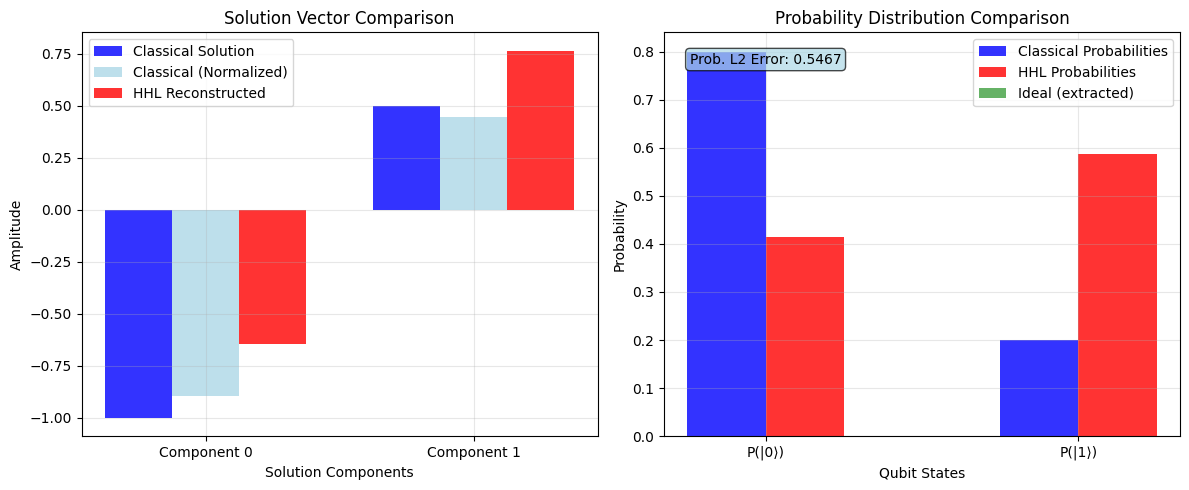


SOLUTION COMPARISON SUMMARY
Classical solution: [-1.   0.5]
Classical norm: 1.118034
HHL probabilities: [0.41339598 0.58660402]
Reconstructed solution: [-0.64295877  0.76590079]
Reconstruction error: 0.405953
Cosine similarity: 0.917601


In [ ]:
import matplotlib.pyplot as plt

def visualize_solution_comparison(analysis_results):
    """Create visual comparison of classical vs HHL solutions"""
    
    classical = analysis_results['classical_solution']
    hhl_probs = analysis_results['hhl_probabilities'] 
    ideal_probs = analysis_results['ideal_probabilities']
    reconstructed = analysis_results['reconstructed_solution']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: Solution vectors comparison
    x_labels = ['Component 0', 'Component 1']
    x_pos = np.arange(len(x_labels))
    
    width = 0.25
    
    # Normalize classical for comparison
    classical_norm = classical / np.linalg.norm(classical)
    
    ax1.bar(x_pos - width, classical, width, label='Classical Solution', alpha=0.8, color='blue')
    ax1.bar(x_pos, classical_norm, width, label='Classical (Normalized)', alpha=0.8, color='lightblue')
    if reconstructed is not None:
        ax1.bar(x_pos + width, reconstructed, width, label='HHL Reconstructed', alpha=0.8, color='red')
    
    ax1.set_xlabel('Solution Components')
    ax1.set_ylabel('Amplitude')
    ax1.set_title('Solution Vector Comparison')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(x_labels)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Probability comparison
    classical_probs = np.abs(classical_norm)**2
    
    ax2.bar(x_pos - width/2, classical_probs, width, label='Classical Probabilities', alpha=0.8, color='blue')
    ax2.bar(x_pos + width/2, hhl_probs, width, label='HHL Probabilities', alpha=0.8, color='red')
    
    if ideal_probs is not None and len(ideal_probs) >= 2:
        # Extract first 2 components if available
        ideal_extracted = ideal_probs[:2] if len(ideal_probs) > 2 else ideal_probs
        ax2.bar(x_pos, ideal_extracted, width/2, label='Ideal (extracted)', alpha=0.6, color='green')
    
    ax2.set_xlabel('Qubit States')
    ax2.set_ylabel('Probability')
    ax2.set_title('Probability Distribution Comparison')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(['P(|0⟩)', 'P(|1⟩)'])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Calculate and display errors
    prob_error = np.linalg.norm(hhl_probs - classical_probs)
    ax2.text(0.05, 0.95, f'Prob. L2 Error: {prob_error:.4f}', transform=ax2.transAxes,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7),
             verticalalignment='top')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\n" + "="*60)
    print("SOLUTION COMPARISON SUMMARY")
    print("="*60)
    print(f"Classical solution: {classical}")
    print(f"Classical norm: {np.linalg.norm(classical):.6f}")
    print(f"HHL probabilities: {hhl_probs}")
    if reconstructed is not None:
        print(f"Reconstructed solution: {reconstructed}")
        reconstruction_error = np.linalg.norm(reconstructed - classical_norm)
        print(f"Reconstruction error: {reconstruction_error:.6f}")
    
    # Calculate cosine similarity if possible
    if reconstructed is not None and len(reconstructed) == len(classical):
        cos_sim = np.dot(reconstructed, classical_norm) / (np.linalg.norm(reconstructed) * np.linalg.norm(classical_norm))
        print(f"Cosine similarity: {cos_sim:.6f}")
    
    print("="*60)

# Run visualization if analysis results are available
if 'analysis_results' in globals():
    visualize_solution_comparison(analysis_results)
else:
    print("Analysis results not found. Run the analysis cell first.")

In [ ]:
# SOLUTION: Fixed Yalovetzky_preprocessing wrapper



# Now use the fixed version
print("Creating fixed Yalovetzky preprocessing...")
fixed_yalovetzky = FixedYalovetzkyPreprocessing(
    clock=k,
    max_eigenvalue=maximum_eigenvalue,
    backend=simulator
)

print("✅ Fixed Yalovetzky preprocessing created successfully!")
print(f"Clock qubits: {fixed_yalovetzky.clock}")
print(f"Max eigenvalue: {fixed_yalovetzky.max_eigenvalue}")
print(f"Backend: {type(fixed_yalovetzky.backend).__name__}")

Creating fixed Yalovetzky preprocessing...
✅ Fixed Yalovetzky preprocessing created successfully!
Clock qubits: 2
Max eigenvalue: 2
Backend: AerSimulator


In [ ]:
# Portfolio Optimization Matrix for HHL (8x8)
import numpy as np
from qiskit.quantum_info import Operator

# Original 6x6 portfolio optimization matrix
W_portfolio_6x6 = np.array([
    [0.         , 0.         , 0.30021458, 0.41119151, 0.43015563, 0.46456748],
    [0.         , 0.         , 1.         , 1.         , 1.         , 1.        ],
    [0.30021458 , 1.         , 0.02369003, 0.01330333, 0.01838175, 0.0216144 ],
    [0.41119151 , 1.         , 0.01330333, 0.03111917, 0.01629131, 0.01887668],
    [0.43015563 , 1.         , 0.01838175, 0.01629131, 0.02885482, 0.02333747],
    [0.46456748 , 1.         , 0.0216144 , 0.01887668, 0.02333747, 0.04412049]
])

# Extend to 8x8 matrix for quantum computation
A_portfolio = np.zeros((8, 8))
A_portfolio[:6, :6] = W_portfolio_6x6

# Portfolio optimization right-hand side vector
mu = 0.1  # 10% expected return
xi = 1.0  
b_portfolio_6 = np.array([mu, xi, 0.0, 0.0, 0.0, 0.0])
b_portfolio = np.zeros(8)
b_portfolio[:6] = b_portfolio_6

print("Portfolio Optimization Matrix (8x8):")
print(A_portfolio)
print(f"\nRHS vector: {b_portfolio}")

# Create quantum problem
problem_portfolio = QuantumLinearSystemProblem(
    A_matrix=A_portfolio,
    b_vector=b_portfolio.reshape(-1, 1)
)

print(f"\n✓ Created 8x8 portfolio problem for HHL")

Portfolio Optimization Matrix (8x8):
[[0.         0.         0.30021458 0.41119151 0.43015563 0.46456748
  0.         0.        ]
 [0.         0.         1.         1.         1.         1.
  0.         0.        ]
 [0.30021458 1.         0.02369003 0.01330333 0.01838175 0.0216144
  0.         0.        ]
 [0.41119151 1.         0.01330333 0.03111917 0.01629131 0.01887668
  0.         0.        ]
 [0.43015563 1.         0.01838175 0.01629131 0.02885482 0.02333747
  0.         0.        ]
 [0.46456748 1.         0.0216144  0.01887668 0.02333747 0.04412049
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]

RHS vector: [0.1 1.  0.  0.  0.  0.  0.  0. ]

✓ Created 8x8 portfolio problem for HHL


## Dynamic Projection Operators for Arbitrary N
Function to create projection operators and solve systems of any size

In [ ]:
def create_projection_operator(index, dimension):
    """
    Create a projection operator |i⟩⟨i| for a given index and dimension.
    
    Parameters:
    - index: The basis state to project onto (0 to dimension-1)
    - dimension: The dimension of the Hilbert space
    
    Returns:
    - Operator: Qiskit Operator representing the projection
    """
    proj_matrix = np.zeros((dimension, dimension))
    proj_matrix[index, index] = 1
    return Operator(proj_matrix)


def solve_linear_system_with_hhl(A_matrix, b_vector, 
                                  preprocessing_type='yalovetzky',
                                  num_clock_qubits=4,
                                  max_eigenvalue=None,
                                  backend=None,
                                  use_enhanced_inversion=True,
                                  verbose=True):
    """
    Solve a linear system Ax = b using HHL algorithm for any matrix size N.
    
    This function:
    1. Automatically determines matrix dimension N
    2. Creates N projection operators dynamically
    3. Runs HHL for each projection to measure each component
    4. Compares results with classical solution
    5. Returns all results and visualizations
    
    Parameters:
    ----------
    A_matrix : np.ndarray
        Coefficient matrix (NxN). Will be hermitianized if not Hermitian.
    b_vector : np.ndarray
        Right-hand side vector (Nx1 or length N)
    preprocessing_type : str
        'yalovetzky', 'lee', or 'ideal' (default: 'yalovetzky')
    num_clock_qubits : int
        Number of clock qubits for HHL (default: 4)
    max_eigenvalue : float
        Maximum eigenvalue estimate. If None, uses largest eigenvalue + 20%
    backend : Backend
        Qiskit backend for execution. If None, uses AerSimulator()
    use_enhanced_inversion : bool
        Use EnhancedHybridInversion if True, else CanonicalInversion (default: True)
    verbose : bool
        Print progress information (default: True)
    
    Returns:
    -------
    dict containing:
        - 'hhl_amplitudes': Measured probability amplitudes from HHL
        - 'classical_solution': Classical solution from np.linalg.solve
        - 'normalized_hhl': Normalized HHL solution
        - 'normalized_classical': Normalized classical solution
        - 'error': L2 error between solutions
        - 'circuit_depth': Circuit depth for the HHL implementation
        - 'A_matrix': Input matrix (possibly hermitianized)
        - 'b_vector': Input vector (possibly extended)
        - 'dimension': System dimension N
    """
    
    # Setup
    if backend is None:
        from qiskit_aer import AerSimulator
        backend = AerSimulator()
    
    # Ensure proper array shapes
    A_matrix = np.array(A_matrix)
    b_vector = np.array(b_vector).flatten().reshape(-1, 1)
    
    N = A_matrix.shape[0]
    
    if verbose:
        print("="*70)
        print(f"SOLVING LINEAR SYSTEM WITH HHL (N={N})")
        print("="*70)
        print(f"Matrix shape: {A_matrix.shape}")
        print(f"Vector shape: {b_vector.shape}")
        print(f"Condition number: {np.linalg.cond(A_matrix):.4f}")
    
    # Check if matrix is Hermitian
    is_hermitian = np.allclose(A_matrix, np.conj(A_matrix.T))
    
    if not is_hermitian:
        if verbose:
            print("⚠️  Matrix is not Hermitian - hermitianizing...")
        A_h, b_h = hermitianize_matrix(A_matrix, b_vector)
        if verbose:
            print(f"   New system size: {A_h.shape}")
            print(f"   Condition number after hermitianization: {np.linalg.cond(A_h):.4f}")
    else:
        A_h, b_h = A_matrix, b_vector
        if verbose:
            print("✓ Matrix is Hermitian")
    
    # Estimate maximum eigenvalue if not provided
    if max_eigenvalue is None:
        eigenvalues = np.linalg.eigvals(A_h)
        max_eigenvalue = np.max(np.abs(eigenvalues)) * 1.2  # 20% buffer
        if verbose:
            print(f"Estimated max eigenvalue: {max_eigenvalue:.4f}")
    
    # Create quantum problem
    problem = QuantumLinearSystemProblem(A_matrix=A_h, b_vector=b_h)
    ideal_x_statevector = QuantumLinearSystemSolver(problem=problem).ideal_x_statevector
    
    # Setup preprocessing
    if preprocessing_type.lower() == 'lee':
        l = num_clock_qubits + 2
        preprocessing = Lee_preprocessing(
            num_eval_qubits=l,
            max_eigenvalue=max_eigenvalue,
            backend=backend
        ).estimate
    elif preprocessing_type.lower() == 'yalovetzky':
        preprocessing = FixedYalovetzkyPreprocessing(
            clock=num_clock_qubits,
            max_eigenvalue=max_eigenvalue,
            backend=backend
        ).estimate
    elif preprocessing_type.lower() == 'ideal':
        preprocessing = ideal_preprocessing
    else:
        raise ValueError(f"Unknown preprocessing type: {preprocessing_type}")
    
    # Setup inversion
    if use_enhanced_inversion:
        eigenvalue_inversion = EnhancedHybridInversion
    else:
        eigenvalue_inversion = CanonicalInversionWrapper
    
    # Dimension of quantum system (may be larger if hermitianized)
    system_dim = A_h.shape[0]
    
    if verbose:
        print(f"\nRunning HHL with {system_dim} projection operators...")
        print(f"Preprocessing: {preprocessing_type}")
        print(f"Inversion: {'Enhanced Hybrid' if use_enhanced_inversion else 'Canonical'}")
        print(f"Clock qubits: {num_clock_qubits}")
    
    # Create projection operators and measure each component
    hhl_probabilities = []
    circuit_depth = None
    
    for i in range(system_dim):
        if verbose:
            print(f"  Measuring component {i}/{system_dim-1}...", end='')
        
        # Create projection operator for this component
        proj_op = create_projection_operator(i, system_dim)
        
        # Run HHL with this projection
        hhl_instance = HHL(
            get_result_function='get_simulator_result',
            preprocessing=preprocessing,
            operator=proj_op,
            eigenvalue_inversion=eigenvalue_inversion,
            backend=backend
        )
        
        result = hhl_instance.estimate(
            problem=problem,
            num_clock_qubits=num_clock_qubits,
            max_eigenvalue=max_eigenvalue
        )
        
        prob = result.results_processed.real
        hhl_probabilities.append(prob)
        
        if circuit_depth is None:
            circuit_depth = result.circuit_depth
        
        if verbose:
            print(f" P(|{i}⟩) = {prob:.6f}")
    
    hhl_probabilities = np.array(hhl_probabilities)
    
    # Get classical solution
    classical_solution = np.linalg.solve(A_h, b_h).flatten()
    
    # Normalize solutions
    normalized_classical = classical_solution / np.linalg.norm(classical_solution)
    normalized_hhl = hhl_probabilities / np.linalg.norm(hhl_probabilities)
    
    # Calculate error
    error = np.linalg.norm(normalized_hhl - normalized_classical)
    
    if verbose:
        print(f"\n{'='*70}")
        print("RESULTS SUMMARY")
        print(f"{'='*70}")
        print(f"Classical solution: {classical_solution}")
        print(f"HHL probabilities:  {hhl_probabilities}")
        print(f"Normalized classical: {normalized_classical}")
        print(f"Normalized HHL:       {normalized_hhl}")
        print(f"L2 Error: {error:.6f}")
        print(f"Circuit Depth: {circuit_depth}")
        print(f"{'='*70}")
    
    return {
        'hhl_amplitudes': hhl_probabilities,
        'classical_solution': classical_solution,
        'normalized_hhl': normalized_hhl,
        'normalized_classical': normalized_classical,
        'error': error,
        'circuit_depth': circuit_depth,
        'A_matrix': A_h,
        'b_vector': b_h,
        'dimension': system_dim,
        'original_dimension': N,
        'ideal_statevector': ideal_x_statevector
    }


def visualize_hhl_results(results, show_plot=True):
    """
    Visualize the comparison between HHL and classical solutions.
    
    Parameters:
    - results: Dictionary returned by solve_linear_system_with_hhl
    - show_plot: Whether to display the plot (default: True)
    """
    import matplotlib.pyplot as plt
    
    classical_norm = results['normalized_classical']
    hhl_norm = results['normalized_hhl']
    N = len(classical_norm)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Normalized solutions comparison
    x = np.arange(N)
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, classical_norm, width, 
                    label='Classical (normalized)', alpha=0.8, color='blue')
    bars2 = ax1.bar(x + width/2, hhl_norm, width,
                    label='HHL (normalized)', alpha=0.8, color='red')
    
    ax1.set_xlabel('Solution Component', fontsize=11)
    ax1.set_ylabel('Normalized Amplitude', fontsize=11)
    ax1.set_title(f'Solution Comparison (N={results["original_dimension"]})', fontsize=12, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels([f'x[{i}]' for i in range(N)])
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    for bar in bars2:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    # Plot 2: Error visualization
    errors = np.abs(hhl_norm - classical_norm)
    bars3 = ax2.bar(x, errors, color='orange', alpha=0.7)
    
    ax2.set_xlabel('Solution Component', fontsize=11)
    ax2.set_ylabel('Absolute Error', fontsize=11)
    ax2.set_title('Component-wise Error', fontsize=12, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels([f'x[{i}]' for i in range(N)])
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add error statistics box
    total_error = results['error']
    max_error = np.max(errors)
    mean_error = np.mean(errors)
    
    textstr = f'Total L2 Error: {total_error:.6f}\\nMax Error: {max_error:.6f}\\nMean Error: {mean_error:.6f}\\nCircuit Depth: {results["circuit_depth"]}'
    props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
    ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=9,
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    
    if show_plot:
        plt.show()
    
    return fig


print("✓ Dynamic HHL solver functions created!")
print("  - create_projection_operator(index, dimension)")
print("  - solve_linear_system_with_hhl(A_matrix, b_vector, ...)")
print("  - visualize_hhl_results(results)")

✓ Dynamic HHL solver functions created!
  - create_projection_operator(index, dimension)
  - solve_linear_system_with_hhl(A_matrix, b_vector, ...)
  - visualize_hhl_results(results)


### Example Usage: 2x2 System

SOLVING LINEAR SYSTEM WITH HHL (N=2)
Matrix shape: (2, 2)
Vector shape: (2, 1)
Condition number: 2.0000
✓ Matrix is Hermitian

Running HHL with 2 projection operators...
Preprocessing: yalovetzky
Inversion: Enhanced Hybrid
Clock qubits: 4
  Measuring component 0/1... P(|0⟩) = 0.929564
  Measuring component 1/1... P(|1⟩) = 0.368662

RESULTS SUMMARY
Classical solution: [ 0.75 -0.25]
HHL probabilities:  [0.92956366 0.36866163]
Normalized classical: [ 0.9486833  -0.31622777]
Normalized HHL:       [0.92956366 0.36866163]
L2 Error: 0.685156
Circuit Depth: 186
 P(|0⟩) = 0.929564
  Measuring component 1/1... P(|1⟩) = 0.368662

RESULTS SUMMARY
Classical solution: [ 0.75 -0.25]
HHL probabilities:  [0.92956366 0.36866163]
Normalized classical: [ 0.9486833  -0.31622777]
Normalized HHL:       [0.92956366 0.36866163]
L2 Error: 0.685156
Circuit Depth: 186


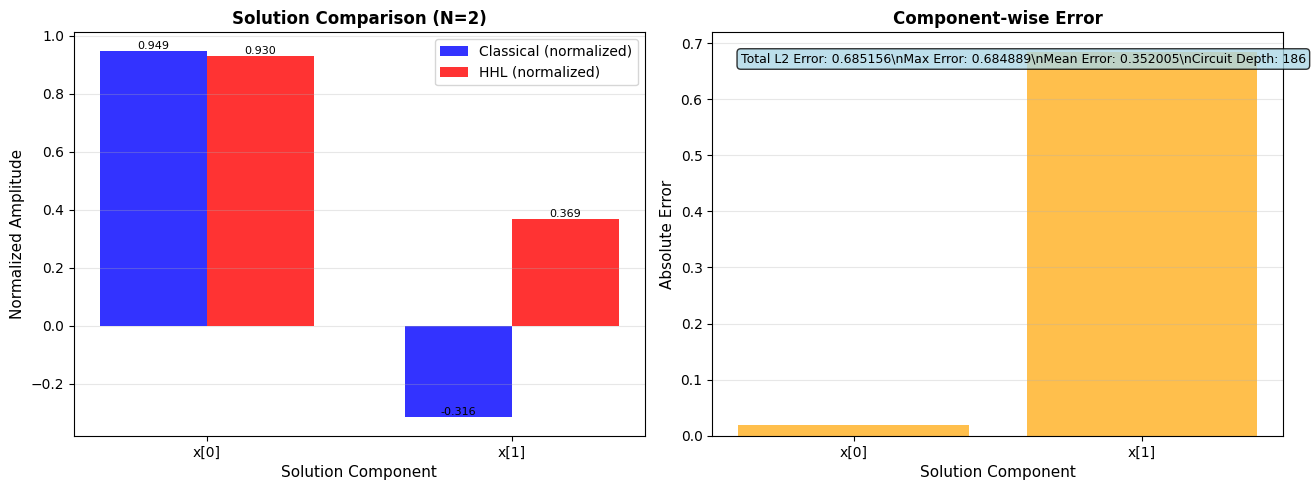

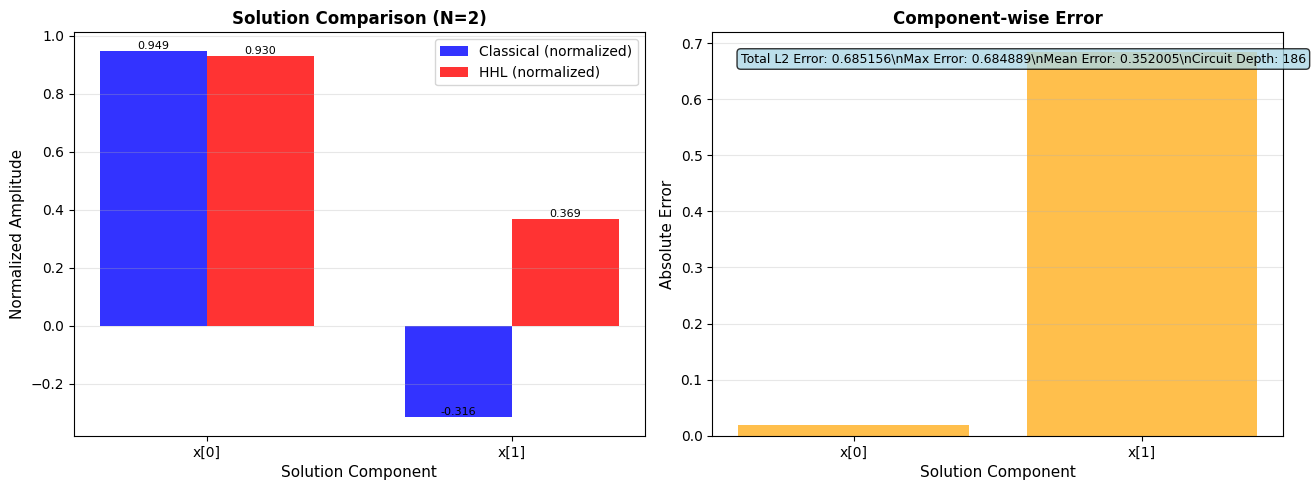

In [103]:
# Example 1: 2x2 Hermitian system
A_2x2 = np.array([[1.5, 0.5], 
                  [0.5, 1.5]])
b_2x2 = np.array([[1.], [0.]])

results_2x2 = solve_linear_system_with_hhl(
    A_2x2, b_2x2,
    preprocessing_type='yalovetzky',
    num_clock_qubits=4,
    max_eigenvalue=3,
    backend=simulator,
    use_enhanced_inversion=True,
    verbose=True
)

visualize_hhl_results(results_2x2)

### Example Usage: 4x4 System

SOLVING LINEAR SYSTEM WITH HHL (N=4)
Matrix shape: (4, 4)
Vector shape: (4, 1)
Condition number: 4.0414
✓ Matrix is Hermitian

Running HHL with 4 projection operators...
Preprocessing: yalovetzky
Inversion: Enhanced Hybrid
Clock qubits: 7
  Measuring component 0/3... P(|0⟩) = 0.689527
  Measuring component 1/3... P(|1⟩) = 0.623284
  Measuring component 2/3... P(|2⟩) = 0.358557
  Measuring component 3/3... P(|3⟩) = 0.086638

RESULTS SUMMARY
Classical solution: [0.48484848 0.40909091 0.25       0.03030303]
HHL probabilities:  [0.68952692 0.62328409 0.3585573  0.08663849]
Normalized classical: [0.71036606 0.59937136 0.3662825  0.04439788]
Normalized HHL:       [0.68952692 0.62328409 0.3585573  0.08663849]
L2 Error: 0.053386
Circuit Depth: 1210


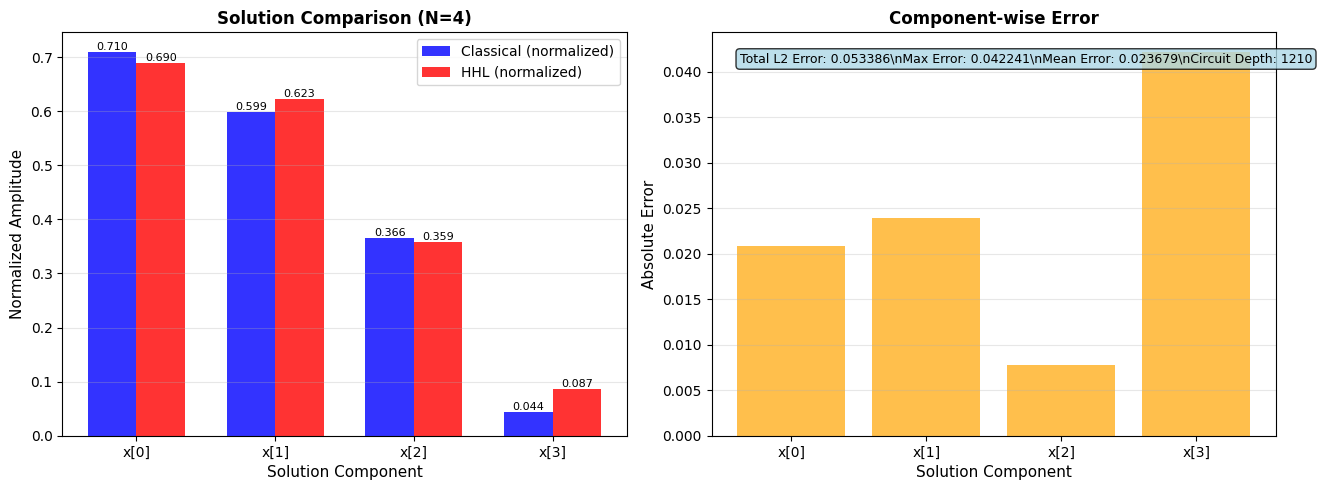

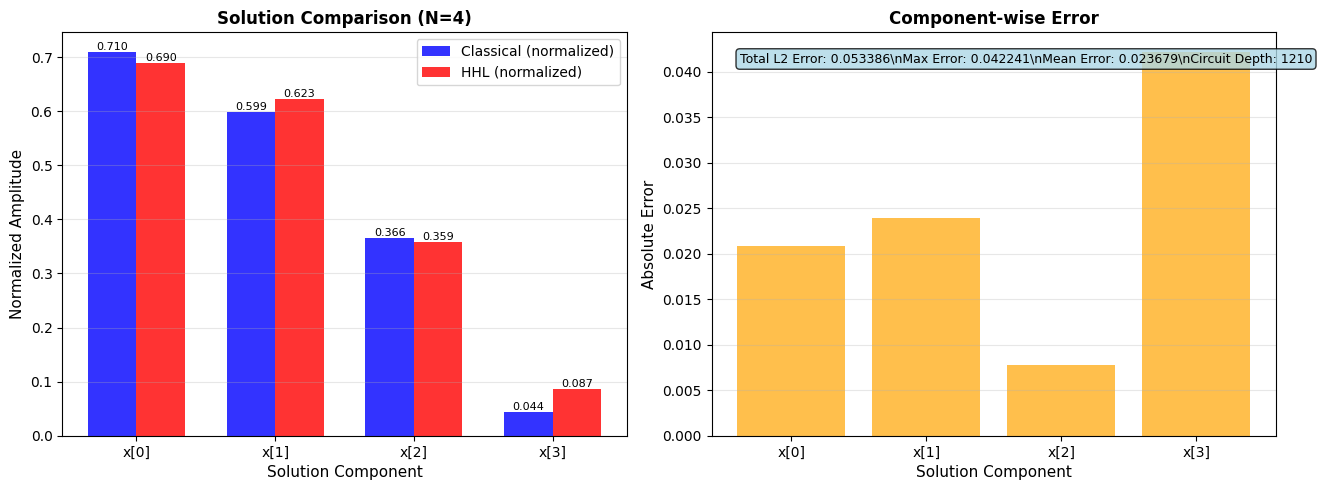

In [84]:
# Example 2: 4x4 system
A_4x4 = np.array([[2, 0, 0, 1],
                  [0, 2, 0, 6],
                  [0, 0, 2, 0],
                  [1, 6, 0, 2]])
b_4x4 = np.array([[1.], [1.], [0.5], [3.]])

results_4x4 = solve_linear_system_with_hhl(
    A_4x4, b_4x4,
    preprocessing_type='yalovetzky',
    num_clock_qubits=7,
    max_eigenvalue=15,
    backend=simulator,
    use_enhanced_inversion=True,
    verbose=True
)

visualize_hhl_results(results_4x4)

### Example Usage: 8x8 Portfolio System

SOLVING LINEAR SYSTEM WITH HHL (N=8)
Matrix shape: (8, 8)
Vector shape: (8, 1)
Condition number: 220027701.7782
✓ Matrix is Hermitian

Running HHL with 8 projection operators...
Preprocessing: yalovetzky
Inversion: Enhanced Hybrid
Clock qubits: 7
  Measuring component 0/7... P(|0⟩) = 0.340737
  Measuring component 1/7... P(|0⟩) = 0.340737
  Measuring component 1/7... P(|1⟩) = 0.139391
  Measuring component 2/7... P(|1⟩) = 0.139391
  Measuring component 2/7... P(|2⟩) = 0.832931
  Measuring component 3/7... P(|2⟩) = 0.832931
  Measuring component 3/7... P(|3⟩) = 0.038323
  Measuring component 4/7... P(|3⟩) = 0.038323
  Measuring component 4/7... P(|4⟩) = 0.135227
  Measuring component 5/7... P(|4⟩) = 0.135227
  Measuring component 5/7... P(|5⟩) = 0.388509
  Measuring component 6/7... P(|5⟩) = 0.388509
  Measuring component 6/7... P(|6⟩) = 0.000000
  Measuring component 7/7... P(|6⟩) = 0.000000
  Measuring component 7/7... P(|7⟩) = 0.000000

RESULTS SUMMARY
Classical solution: [ 0.1542689

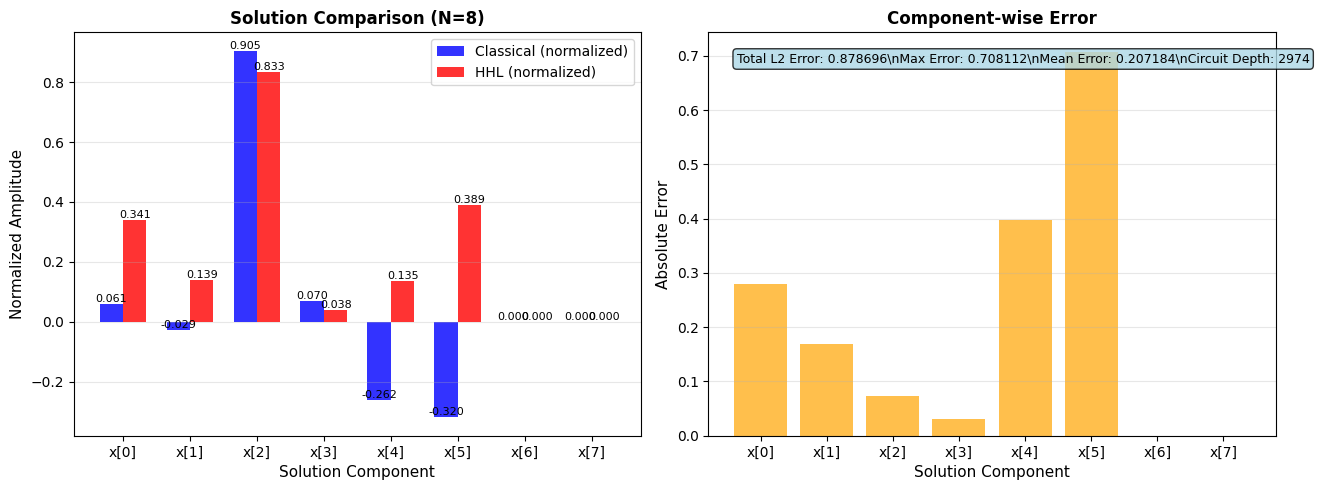

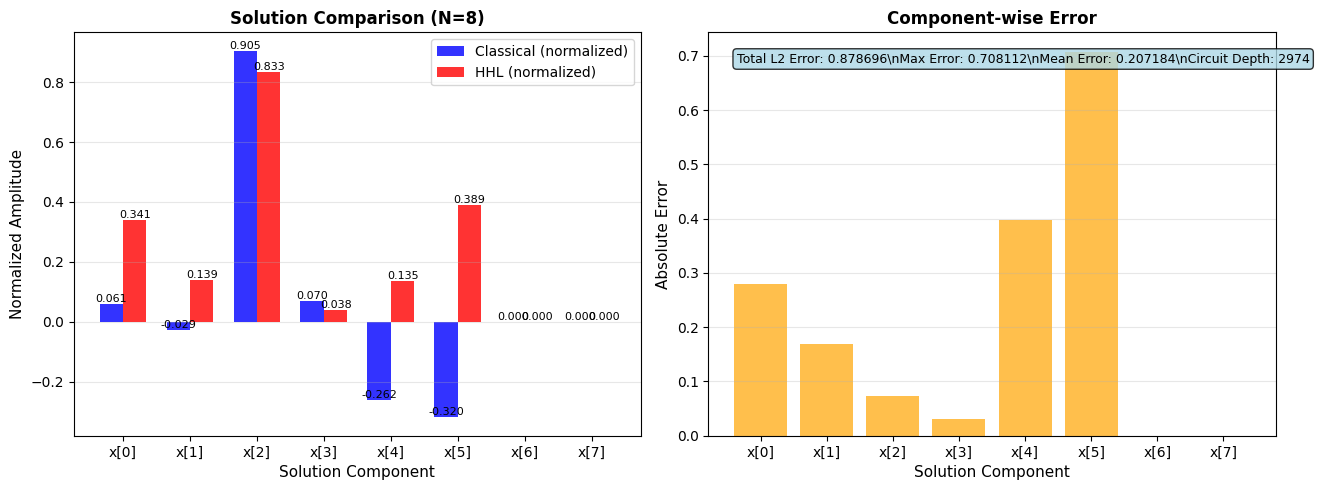

In [104]:
# Example 3: 8x8 Portfolio optimization system
# (Using the portfolio matrix defined earlier)

results_8x8 = solve_linear_system_with_hhl(
    A_portfolio, b_portfolio,
    preprocessing_type='yalovetzky',
    num_clock_qubits=7,
    max_eigenvalue=5,
    backend=simulator,
    use_enhanced_inversion=True,
    verbose=True
)

visualize_hhl_results(results_8x8)

### Example Usage: Non-Hermitian System (Auto-hermitianization)

Testing with non-Hermitian matrix:
The function will automatically hermitianize it.

SOLVING LINEAR SYSTEM WITH HHL (N=2)
Matrix shape: (2, 2)
Vector shape: (2, 1)
Condition number: 2.3131
⚠️  Matrix is not Hermitian - hermitianizing...
   New system size: (4, 4)
   Condition number after hermitianization: 2.3131

Running HHL with 4 projection operators...
Preprocessing: yalovetzky
Inversion: Enhanced Hybrid
Clock qubits: 7
  Measuring component 0/3... P(|0⟩) = 0.072496
  Measuring component 1/3... P(|0⟩) = 0.072496
  Measuring component 1/3... P(|1⟩) = 0.140527
  Measuring component 2/3... P(|1⟩) = 0.140527
  Measuring component 2/3... P(|2⟩) = 0.835994
  Measuring component 3/3... P(|2⟩) = 0.835994
  Measuring component 3/3... P(|3⟩) = 0.525463

RESULTS SUMMARY
Classical solution: [ 0.          0.          0.18181364 -0.11363227]
HHL probabilities:  [0.07249573 0.14052678 0.83599365 0.52546285]
Normalized classical: [ 0.          0.          0.84800092 -0.52999475]
Normalized HHL:   

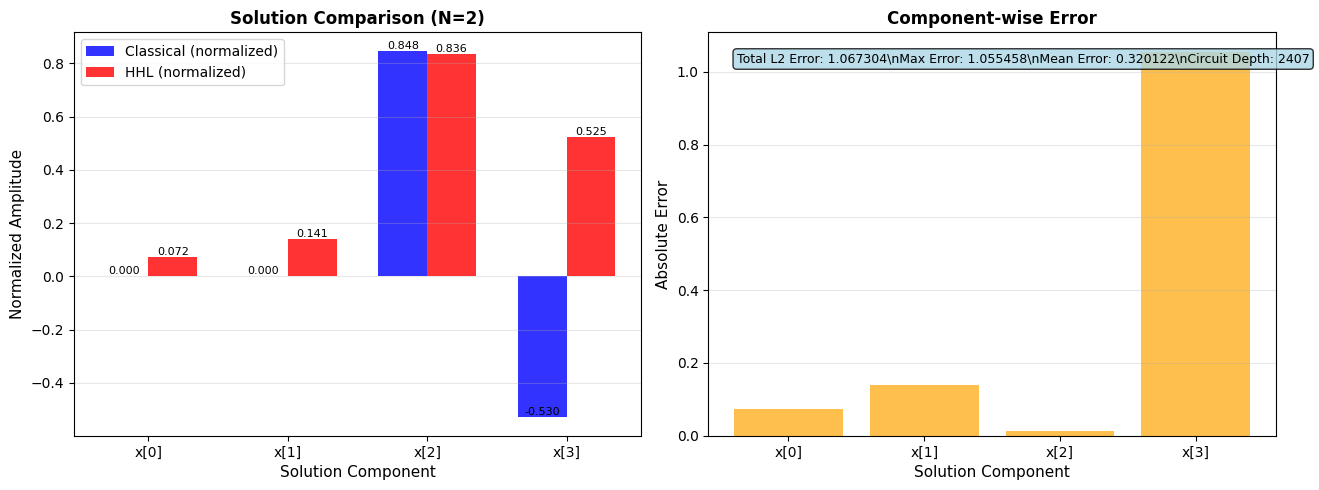

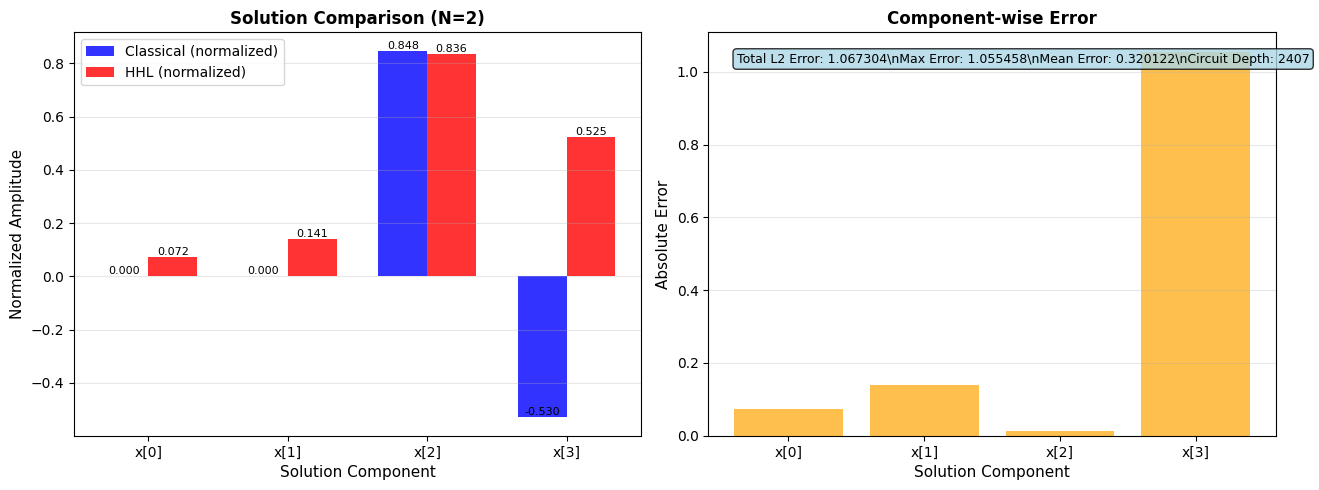

In [ ]:
# Example 4: Non-Hermitian system (will be automatically hermitianized)
A_non_hermitian = np.array([[22, 0], 
                            [18, 20]])
b_non_hermitian = np.array([[3.9999], [1.]])

print("Testing with non-Hermitian matrix:")
print("The function will automatically hermitianize it.\n")

results_non_herm = solve_linear_system_with_hhl(
    A_non_hermitian, b_non_hermitian,
    preprocessing_type='yalovetzky',
    num_clock_qubits=7,
    max_eigenvalue=40,
    backend=simulator,
    use_enhanced_inversion=True,
    verbose=True
)

visualize_hhl_results(results_non_herm)

## HHL Circuit Depth Experiment
Measuring circuit depth for different matrix sizes N = 2 to 32

In [96]:
import matplotlib.pyplot as plt
import time

# Experiment parameters
matrix_sizes = [2**i for i in range(1,5)] # 2, 3, 4, ..., 32
num_trials = 5

# Storage for results
average_circuit_depths = []
std_circuit_depths = []
average_errors = []
average_execution_times = []
std_execution_times = []

print("="*70)
print("HHL CIRCUIT DEPTH EXPERIMENT")
print("="*70)
print(f"Matrix sizes: {matrix_sizes[0]} to {matrix_sizes[-1]}")
print(f"Trials per size: {num_trials}")
print(f"Total runs: {len(matrix_sizes) * num_trials}")
print("="*70)
print(f"{'N':<5} {'Avg Depth':<12} {'Std Depth':<12} {'Avg Time (s)':<14} {'Avg Error':<12} {'Status'}")
print("-"*80)

for N in matrix_sizes:
    trial_depths = []
    trial_errors = []
    trial_times = []
    
    for trial in range(num_trials):
        # Generate random symmetric matrix
        A_matrix = np.random.rand(N, N)
        A_matrix = A_matrix + A_matrix.T  # Make symmetric
        b_vector = np.random.rand(N, 1)
        
        # Determine appropriate parameters based on matrix size
        k=6
        max_eig =40
        # if N <= 4:
        #     k = 4
        #     max_eig = 5
        # elif N <= 8:
        #     k = 5
        #     max_eig = 10
        # elif N <= 16:
        #     k = 6
        #     max_eig = 20
        # else:
        #     k = 7
        #     max_eig = 40
        
        try:
            # Measure execution time
            start_time = time.time()
            
            # Run HHL
            result = solve_linear_system_with_hhl(
                A_matrix, b_vector,
                preprocessing_type='yalovetzky',
                num_clock_qubits=k,
                max_eigenvalue=max_eig,
                backend=simulator,
                use_enhanced_inversion=True,
                verbose=False  # Suppress output for cleaner display
            )
            
            end_time = time.time()
            execution_time = end_time - start_time
            
            trial_depths.append(result['circuit_depth'])
            trial_errors.append(result['error'])
            trial_times.append(execution_time)
            
        except Exception as e:
            print(f"  Error at N={N}, trial={trial}: {str(e)[:50]}")
            continue
    
    if trial_depths:  # If we have successful trials
        avg_depth = np.mean(trial_depths)
        std_depth = np.std(trial_depths)
        avg_error = np.mean(trial_errors)
        avg_time = np.mean(trial_times)
        std_time = np.std(trial_times)
        
        average_circuit_depths.append(avg_depth)
        std_circuit_depths.append(std_depth)
        average_errors.append(avg_error)
        average_execution_times.append(avg_time)
        std_execution_times.append(std_time)
        
        print(f"{N:<5} {avg_depth:<12.2f} {std_depth:<12.2f} {avg_time:<14.4f} {avg_error:<12.6f} {'✓'}")
    else:
        # If all trials failed, use None
        average_circuit_depths.append(None)
        std_circuit_depths.append(None)
        average_errors.append(None)
        average_execution_times.append(None)
        std_execution_times.append(None)
        print(f"{N:<5} {'N/A':<12} {'N/A':<12} {'N/A':<14} {'N/A':<12} {'✗'}")

print("="*70)
print("Experiment completed!")
print("="*70)

HHL CIRCUIT DEPTH EXPERIMENT
Matrix sizes: 2 to 16
Trials per size: 5
Total runs: 20
N     Avg Depth    Std Depth    Avg Time (s)   Avg Error    Status
--------------------------------------------------------------------------------
2     313.80       25.60        0.4582         0.864835     ✓
2     313.80       25.60        0.4582         0.864835     ✓
4     495.40       131.78       0.8132         1.128628     ✓
4     495.40       131.78       0.8132         1.128628     ✓
8     1127.00      73.10        4.2186         1.266271     ✓
8     1127.00      73.10        4.2186         1.266271     ✓
16    3210.20      108.47       68.0608        1.413151     ✓
Experiment completed!
16    3210.20      108.47       68.0608        1.413151     ✓
Experiment completed!


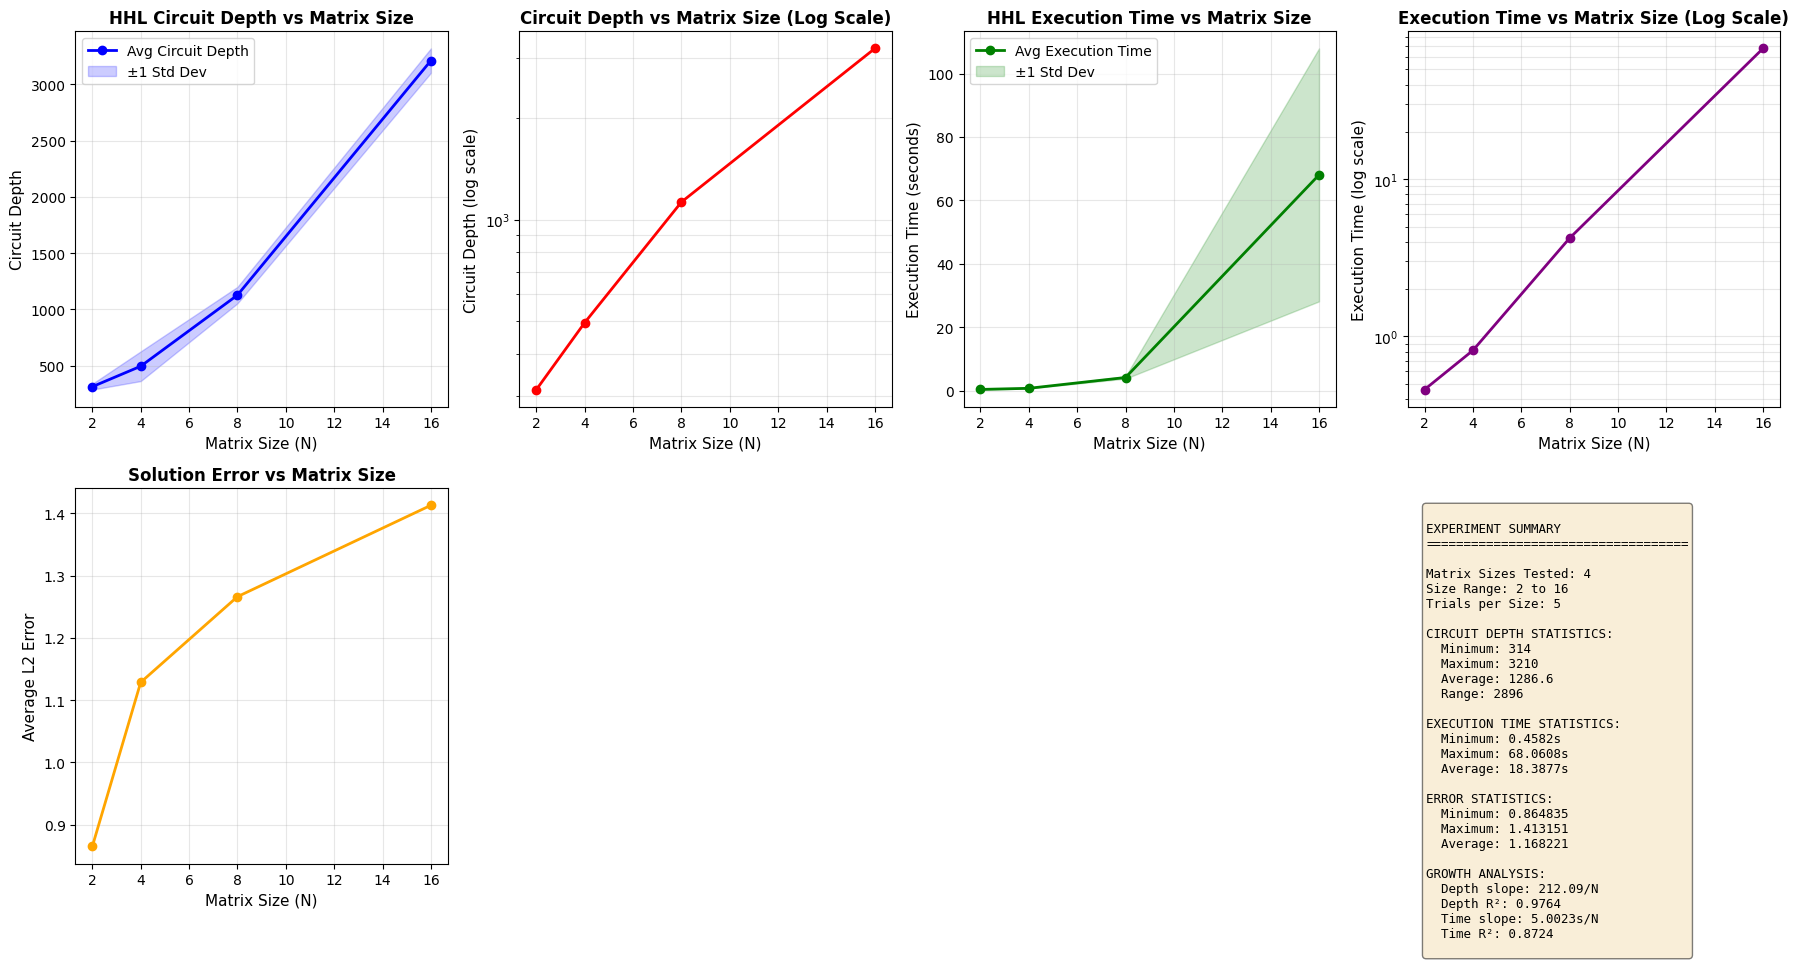


FINAL SUMMARY
Smallest matrix (N=2): Circuit depth = 314, Time = 0.4582s
Largest matrix (N=16):  Circuit depth = 3210, Time = 68.0608s
Depth increase: 10.23x
Time increase: 148.53x
Average circuit depth across all sizes: 1286.6
Average execution time across all sizes: 18.3877s
Average solution error across all sizes: 1.168221


In [98]:
# Filter out None values for plotting
valid_indices = [i for i, depth in enumerate(average_circuit_depths) if depth is not None]
valid_sizes = [matrix_sizes[i] for i in valid_indices]
valid_depths = [average_circuit_depths[i] for i in valid_indices]
valid_std = [std_circuit_depths[i] for i in valid_indices]
valid_errors = [average_errors[i] for i in valid_indices]
valid_times = [average_execution_times[i] for i in valid_indices]
valid_std_times = [std_execution_times[i] for i in valid_indices]

# Create comprehensive visualization
fig = plt.figure(figsize=(18, 10))

# Plot 1: Circuit Depth vs Matrix Size (Linear)
ax1 = plt.subplot(2, 4, 1)
ax1.plot(valid_sizes, valid_depths, 'o-', linewidth=2, markersize=6, color='blue', label='Avg Circuit Depth')
ax1.fill_between(valid_sizes, 
                  [d - s for d, s in zip(valid_depths, valid_std)],
                  [d + s for d, s in zip(valid_depths, valid_std)],
                  alpha=0.2, color='blue', label='±1 Std Dev')
ax1.set_xlabel('Matrix Size (N)', fontsize=11)
ax1.set_ylabel('Circuit Depth', fontsize=11)
ax1.set_title('HHL Circuit Depth vs Matrix Size', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Circuit Depth vs Matrix Size (Log-Linear)
ax2 = plt.subplot(2, 4, 2)
ax2.semilogy(valid_sizes, valid_depths, 'o-', linewidth=2, markersize=6, color='red')
ax2.set_xlabel('Matrix Size (N)', fontsize=11)
ax2.set_ylabel('Circuit Depth (log scale)', fontsize=11)
ax2.set_title('Circuit Depth vs Matrix Size (Log Scale)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, which='both')

# Plot 3: Execution Time vs Matrix Size (Linear)
ax3 = plt.subplot(2, 4, 3)
ax3.plot(valid_sizes, valid_times, 'o-', linewidth=2, markersize=6, color='green', label='Avg Execution Time')
ax3.fill_between(valid_sizes,
                  [t - s for t, s in zip(valid_times, valid_std_times)],
                  [t + s for t, s in zip(valid_times, valid_std_times)],
                  alpha=0.2, color='green', label='±1 Std Dev')
ax3.set_xlabel('Matrix Size (N)', fontsize=11)
ax3.set_ylabel('Execution Time (seconds)', fontsize=11)
ax3.set_title('HHL Execution Time vs Matrix Size', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend()

# Plot 4: Execution Time vs Matrix Size (Log-Linear)
ax4 = plt.subplot(2, 4, 4)
ax4.semilogy(valid_sizes, valid_times, 'o-', linewidth=2, markersize=6, color='purple')
ax4.set_xlabel('Matrix Size (N)', fontsize=11)
ax4.set_ylabel('Execution Time (log scale)', fontsize=11)
ax4.set_title('Execution Time vs Matrix Size (Log Scale)', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, which='both')

# Plot 5: Error vs Matrix Size
ax5 = plt.subplot(2, 4, 5)
ax5.plot(valid_sizes, valid_errors, 'o-', linewidth=2, markersize=6, color='orange')
ax5.set_xlabel('Matrix Size (N)', fontsize=11)
ax5.set_ylabel('Average L2 Error', fontsize=11)
ax5.set_title('Solution Error vs Matrix Size', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3)

# Plot 6: Circuit Depth per Qubit
# ax6 = plt.subplot(2, 4, 6)
# depth_per_n = [d / n for d, n in zip(valid_depths, valid_sizes)]
# ax6.plot(valid_sizes, depth_per_n, 'o-', linewidth=2, markersize=6, color='brown')
# ax6.set_xlabel('Matrix Size (N)', fontsize=11)
# ax6.set_ylabel('Circuit Depth / N', fontsize=11)
# ax6.set_title('Circuit Depth per Matrix Dimension', fontsize=12, fontweight='bold')
# ax6.grid(True, alpha=0.3)

# Plot 7: Time per Matrix Dimension
# ax7 = plt.subplot(2, 4, 7)
# time_per_n = [t / n for t, n in zip(valid_times, valid_sizes)]
# ax7.plot(valid_sizes, time_per_n, 'o-', linewidth=2, markersize=6, color='teal')
# ax7.set_xlabel('Matrix Size (N)', fontsize=11)
# ax7.set_ylabel('Execution Time / N (s)', fontsize=11)
# ax7.set_title('Execution Time per Matrix Dimension', fontsize=12, fontweight='bold')
# ax7.grid(True, alpha=0.3)

# Plot 8: Statistics Summary
ax8 = plt.subplot(2, 4, 8)
ax8.axis('off')

# Calculate statistics
min_depth = min(valid_depths)
max_depth = max(valid_depths)
avg_all_depths = np.mean(valid_depths)
min_error = min(valid_errors)
max_error = max(valid_errors)
avg_all_errors = np.mean(valid_errors)
min_time = min(valid_times)
max_time = max(valid_times)
avg_all_times = np.mean(valid_times)

# Growth rate estimation (if enough points)
if len(valid_sizes) > 2:
    # Simple linear fit for growth rate
    from scipy.stats import linregress
    slope, intercept, r_value, p_value, std_err = linregress(valid_sizes, valid_depths)
    growth_rate = slope
    
    slope_time, intercept_time, r_value_time, _, _ = linregress(valid_sizes, valid_times)
    growth_rate_time = slope_time
else:
    growth_rate = None
    growth_rate_time = None

stats_text = f"""
EXPERIMENT SUMMARY
{'='*35}

Matrix Sizes Tested: {len(valid_sizes)}
Size Range: {min(valid_sizes)} to {max(valid_sizes)}
Trials per Size: {num_trials}

CIRCUIT DEPTH STATISTICS:
  Minimum: {min_depth:.0f}
  Maximum: {max_depth:.0f}
  Average: {avg_all_depths:.1f}
  Range: {max_depth - min_depth:.0f}

EXECUTION TIME STATISTICS:
  Minimum: {min_time:.4f}s
  Maximum: {max_time:.4f}s
  Average: {avg_all_times:.4f}s

ERROR STATISTICS:
  Minimum: {min_error:.6f}
  Maximum: {max_error:.6f}
  Average: {avg_all_errors:.6f}

"""

if growth_rate is not None:
    stats_text += f"""GROWTH ANALYSIS:
  Depth slope: {growth_rate:.2f}/N
  Depth R²: {r_value**2:.4f}
  Time slope: {growth_rate_time:.4f}s/N
  Time R²: {r_value_time**2:.4f}
"""

ax8.text(0.05, 0.95, stats_text, transform=ax8.transAxes,
         fontsize=9, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print final summary
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)
print(f"Smallest matrix (N={min(valid_sizes)}): Circuit depth = {valid_depths[0]:.0f}, Time = {valid_times[0]:.4f}s")
print(f"Largest matrix (N={max(valid_sizes)}):  Circuit depth = {valid_depths[-1]:.0f}, Time = {valid_times[-1]:.4f}s")
print(f"Depth increase: {valid_depths[-1]/valid_depths[0]:.2f}x")
print(f"Time increase: {valid_times[-1]/valid_times[0]:.2f}x")
print(f"Average circuit depth across all sizes: {avg_all_depths:.1f}")
print(f"Average execution time across all sizes: {avg_all_times:.4f}s")
print(f"Average solution error across all sizes: {avg_all_errors:.6f}")
print("="*80)

### Save Experiment Data (Optional)

In [99]:
# Optional: Save experiment data to JSON for later analysis
import json
from datetime import datetime

experiment_data = {
    'timestamp': datetime.now().isoformat(),
    'experiment_type': 'HHL_circuit_depth',
    'parameters': {
        'matrix_sizes': matrix_sizes,
        'num_trials': num_trials,
        'preprocessing_type': 'yalovetzky',
        'use_enhanced_inversion': True
    },
    'results': {
        'matrix_sizes': valid_sizes,
        'average_circuit_depths': valid_depths,
        'std_circuit_depths': valid_std,
        'average_errors': valid_errors,
        'average_execution_times': valid_times,
        'std_execution_times': valid_std_times
    }
}

# Uncomment to save
with open('hhl_circuit_depth_experiment_2.json', 'w') as f:
    json.dump(experiment_data, f, indent=2)
print("✓ Experiment data saved to 'hhl_circuit_depth_experiment.json'")

print("✓ Experiment data ready for export")
print(f"  Data points collected: {len(valid_sizes)}")
print(f"  To save, uncomment the code above")

✓ Experiment data saved to 'hhl_circuit_depth_experiment.json'
✓ Experiment data ready for export
  Data points collected: 4
  To save, uncomment the code above
